In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the unified pipeline results
df = pd.read_csv('../../results/all/experiment_results.csv')

# Separate synthetic and real datasets
df_synthetic = df[df['data_type'] == 'synthetic'].copy()
df_real = df[df['data_type'] == 'real'].copy()

print(f"Synthetic datasets: {df_synthetic.shape[0]} rows")
print(f"Real datasets: {df_real.shape[0]} rows")

# Data preparation
df_synthetic['f1'] = pd.to_numeric(df_synthetic['f1'], errors='coerce')
df_synthetic['accuracy'] = pd.to_numeric(df_synthetic['accuracy'], errors='coerce')
df_synthetic['n_selected'] = pd.to_numeric(df_synthetic['n_selected'], errors='coerce')

df_real['f1'] = pd.to_numeric(df_real['f1'], errors='coerce')
df_real['accuracy'] = pd.to_numeric(df_real['accuracy'], errors='coerce')
df_real['n_selected'] = pd.to_numeric(df_real['n_selected'], errors='coerce')

# Define models and colors
MODELS = df['model_name'].unique().tolist()
PALETTE = {model: f'C{i}' for i, model in enumerate(MODELS)}

print(f"Models: {MODELS}")

# SYNTHETIC DATA ANALYSIS
if len(df_synthetic) > 0:
    print("\n" + "=" * 80)
    print("SYNTHETIC DATA ANALYSIS")
    print("=" * 80)
    
    # Scenario order (synthetic only)
    scenario_order = ['A', 'B', 'C', 'D']
    scenario_order = [s for s in scenario_order if s in df_synthetic['scenario'].unique()]
    
    # Number of Selected Features with Ground Truth Reference
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_synthetic, x='scenario', y='n_selected', hue='model_name', palette=PALETTE)
    plt.title('Number of Selected Features by Scenario and Model (Synthetic Data)')
    plt.xlabel('Scenario')
    plt.ylabel('Number of Selected Features')
    
    # Add ground truth reference lines
    for i, scen in enumerate(scenario_order):
        # Get true number of features for this scenario
        scen_data = df_synthetic[df_synthetic['scenario'] == scen]
        true_support = json.loads(scen_data['true_support'].iloc[0])
        n_true_features = len(true_support)
        
        # Add horizontal line for ground truth
        plt.axhline(y=n_true_features, xmin=i/len(scenario_order) + 0.1, xmax=(i+1)/len(scenario_order) - 0.1, 
                    color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add text label for ground truth
        plt.text(i, n_true_features + 0.5, f'True: {n_true_features}', 
                 ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')
    
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Individual scenario plots for number of selected features
    n_scenarios = len(scenario_order)
    n_cols = 2
    n_rows = (n_scenarios + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_scenarios == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, scen in enumerate(scenario_order):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        scen_data = df_synthetic[df_synthetic['scenario'] == scen]
        desc = scen_data['scenario_description'].iloc[0]
        
        sns.boxplot(data=scen_data, x='model_name', y='n_selected', palette=PALETTE, ax=ax, hue='model_name')
        ax.set_title(f'Scenario {scen}: Number of Selected Features\n{desc}')
        ax.set_xlabel('Model')
        ax.set_ylabel('Number of Selected Features')
        
        # Add ground truth reference line
        true_support = json.loads(scen_data['true_support'].iloc[0])
        n_true_features = len(true_support)
        ax.axhline(y=n_true_features, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'True: {n_true_features}')
        
        # Add text label for ground truth
        ax.text(0.5, n_true_features + 0.5, f'True: {n_true_features}', 
                ha='center', va='bottom', fontsize=10, color='red', fontweight='bold', 
                transform=ax.transData)
        
        # Dynamic y-axis for better visualization
        n_sel_values = scen_data['n_selected'].dropna()
        if len(n_sel_values) > 0:
            min_val = n_sel_values.min()
            max_val = n_sel_values.max()
            if max_val > min_val:
                padding = (max_val - min_val) * 0.05
                ax.set_ylim(min_val - padding, max_val + padding)
            else:
                ax.set_ylim(min_val - 0.01, min_val + 0.01)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide any unused subplots
    for i in range(n_scenarios, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    # Coefficient Analysis with Best Iteration Comparison (Synthetic Data)
    print("\n" + "=" * 80)
    print("COEFFICIENT ANALYSIS WITH BEST ITERATION COMPARISON (SYNTHETIC)")
    print("=" * 80)

    TOPK = 20  # Number of top features to show

    for scen in scenario_order:
        # Get the first row to extract true beta (same for all iterations in a scenario)
        row = df_synthetic[df_synthetic["scenario"] == scen].iloc[0]
        beta_true_raw = json.loads(row["beta_true"])
        true_support = json.loads(row["true_support"])
        b0_true_raw = 0.0  # Default intercept

        p = len(beta_true_raw)
        
        # Get features selected by any model
        model_selected_features = set()
        for m in MODELS:
            sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
            if len(sub) > 0:
                coefs_dict = json.loads(sub.iloc[0]["coefficients"])
                coefs = coefs_dict.get("values", [])
                if coefs:
                    non_zero_idx = np.where(np.array(coefs) != 0)[0]
                    model_selected_features.update(non_zero_idx)
        
        # Combine true features with model-selected features
        all_important_features = set(true_support) | model_selected_features
        all_important_features = sorted(list(all_important_features))
        
        # Take top features, prioritizing true features first
        true_features_first = true_support + [f for f in all_important_features if f not in true_support]
        top_idx = true_features_first[:min(TOPK, len(true_features_first))]
        
        labels = [f"f{j}" for j in top_idx]
        
        print(f"\nScenario {scen}:")
        print(f"  True features: {true_support}")
        print(f"  Features selected by any model: {sorted(list(model_selected_features))}")
        print(f"  Features: {labels}")

        # Collect coefficients from ALL iterations for error bar calculation
        all_coefs = {model: [] for model in MODELS}
        beta_true_std = None  # Will be computed once using the first model's scaler
        b0_true_std = None

        for m in MODELS:
            sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
            if len(sub) == 0:
                continue
                
            for _, model_row in sub.iterrows():
                try:
                    coefs_dict = json.loads(model_row["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    mu = coefs_dict.get("mean", np.zeros(p))
                    s = coefs_dict.get("scale", np.ones(p))
                    
                    # Convert true beta to standardized space using this model's scaler
                    if beta_true_std is None:
                        beta_true_std, b0_true_std = raw_to_std(beta_true_raw, b0_true_raw, mu, s, true_support)

                    if coefs and len(coefs) == len(mu):
                        coefs_array = np.array(coefs)[top_idx]
                        all_coefs[m].append(coefs_array)
                        
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
                    continue

        # Calculate means and standard errors for each model
        model_means = {}
        model_stds = {}
        
        for m in MODELS:
            if len(all_coefs[m]) > 0:
                coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
                model_means[m] = np.mean(coefs_matrix, axis=0)
                model_stds[m] = np.std(coefs_matrix, axis=0)
            else:
                print(f"Warning: No valid coefficients for {m} in scenario {scen}")

        # Plot coefficient comparison if we have valid data
        if beta_true_std is not None and len(model_means) > 0:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(labels))
            width = 0.35  # Width of bars
            
            # True coefficients (standardized) - as horizontal line
            beta_true_top = beta_true_std[top_idx]
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
                    # Plot bars for each model
        for i, (model, means) in enumerate(model_means.items()):
            stds = model_stds[model]
            x_pos = x + i * width - width/2  # Offset bars
            bars = plt.bar(x_pos, means, width, 
                          label=f'{model}', 
                          color=PALETTE[model], 
                          alpha=0.8,
                          yerr=stds, 
                          capsize=5,
                          error_kw={'elinewidth': 1, 'capthick': 1})
        
        # Add true coefficients as red circles (outside the loop!)
        plt.scatter(x, beta_true_top, 
                   color='red', s=150, marker='o', 
                   label='True (Standardized)', zorder=10, linewidth=2)
            
            plt.xlabel('Features (True + Model-Selected)')
            plt.ylabel('Coefficient Value (Standardized)')
            plt.title(f'Scenario {scen}: Coefficient Comparison with Error Bars\n(True + Model-Selected Features)')
            plt.xticks(x, labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Find best iteration for each model
            best_iterations = {}
            for m in MODELS:
                sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
                if len(sub) > 0:
                    f1_scores = sub['f1'].dropna()
                    if len(f1_scores) > 0:
                        best_idx = f1_scores.idxmax()
                        best_iterations[m] = sub.loc[best_idx]
                    else:
                        best_iterations[m] = sub.iloc[0]  # Fallback to first iteration
            
            # Best Iteration Coefficient Comparison (parallel to coefficient analysis)
            print(f"\n--- SCENARIO {scen} - BEST ITERATION COEFFICIENTS ---")
            
            # Get coefficients from best iterations
            best_coefs = {}
            best_feature_labels = None
            
            for m in MODELS:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    try:
                        coefs_dict = json.loads(best_iter["coefficients"])
                        coefs = coefs_dict.get("values", [])
                        if coefs and len(coefs) > 0:
                            coefs_array = np.array(coefs)
                            # Get top features by absolute coefficient value
                            abs_coefs = np.abs(coefs_array)
                            top_idx = np.argsort(abs_coefs)[::-1][:min(15, len(coefs_array))]
                            
                            best_coefs[m] = coefs_array[top_idx]
                            
                            if best_feature_labels is None:
                                best_feature_labels = [f"f{i}" for i in top_idx]
                            
                            print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                    except Exception as e:
                        print(f"Warning: Could not parse coefficients for {m}: {e}")
            
                    # Plot best iteration coefficients if we have data
        if len(best_coefs) > 0 and best_feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(best_feature_labels))
            width = 0.35
            
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Calculate true coefficients in standardized space for the first model
            true_coefs_std = None
            if len(best_coefs) > 0:
                first_model = list(best_coefs.keys())[0]
                first_iter = best_iterations[first_model]
                try:
                    coefs_dict = json.loads(first_iter["coefficients"])
                    mu = coefs_dict.get("mean", np.zeros(len(best_feature_labels)))
                    s = coefs_dict.get("scale", np.ones(len(best_feature_labels)))
                    
                    # Convert true beta to standardized space
                    true_coefs_std, _ = raw_to_std(beta_true_raw, 0.0, mu, s, true_support)
                    true_coefs_std = true_coefs_std[top_idx]  # Select same features as in plot
                except Exception as e:
                    print(f"Warning: Could not calculate true coefficients: {e}")
                    true_coefs_std = None
            
            # Plot bars for each model's best iteration
            for i, (model, coefs) in enumerate(best_coefs.items()):
                best_iter = best_iterations[model]
                x_pos = x + i * width - width/2
                
                # Use model colors from PALETTE, with different alpha for selected vs non-selected
                base_color = PALETTE[model]
                colors = [base_color if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                
                bars = plt.bar(x_pos, coefs, width, 
                              label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                              color=colors, alpha=0.8)
            
            # Add true features as circles (using actual true coefficients)
            true_features_in_plot = [i for i, f in enumerate(best_feature_labels) if int(f[1:]) in true_support]
            if true_features_in_plot and true_coefs_std is not None:
                true_coefs_plot = [true_coefs_std[i] for i in true_features_in_plot]
                plt.scatter([x[i] for i in true_features_in_plot], true_coefs_plot, 
                           color='blue', s=150, marker='o', 
                           label='True Features', zorder=10, linewidth=2)
                
                plt.xlabel('Features (Top 15 by Coefficient Magnitude)')
                plt.ylabel('Coefficient Value (Standardized)')
                plt.title(f'Scenario {scen}: Best Iteration Coefficient Comparison\n(Colored = Selected, Gray = Not Selected, Blue o = True Features)')
                plt.xticks(x, best_feature_labels, rotation=45)
                plt.legend()
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
                
                # Print summary of selected features
                print(f"\nSelected Features Summary:")
                for model, coefs in best_coefs.items():
                    selected_mask = np.abs(coefs) > 1e-6
                    selected_features = [best_feature_labels[i] for i in range(len(best_feature_labels)) if selected_mask[i]]
                    selected_values = coefs[selected_mask]
                    print(f"  {model.upper()}: {len(selected_features)} features - {selected_features}")
                    print(f"    Values: {[f'{v:.3f}' for v in selected_values]}")
                
                # Show true features
                print(f"  TRUE FEATURES: {[f'f{i}' for i in true_support]}")
            
            else:
                print(f"No valid coefficient data for scenario {scen}")
            
            # Print detailed summary statistics
            print(f"\n" + "="*60)
            print(f"SCENARIO {scen} - DETAILED ANALYSIS")
            print(f"="*60)
            
            print(f"Features: {labels}")
            print(f"True features: {true_support}")
            print(f"True beta values: {[f'{beta_true_raw[i]:.3f}' for i in true_support]}")
            print(f"Mean |β| (true): {np.mean(np.abs(beta_true_top)):.3f}")
            
            # Show which iterations had best performance
            print(f"\nBest iterations:")
            for m in MODELS:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    print(f"  {m.upper()}: Iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f})")
            
            print(f"\n--- MODEL PERFORMANCE ---")
            for m in MODELS:
                if m in model_means:
                    # Get detailed info for this model
                    sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
                    
                    # Average features selected across all iterations
                    n_selected_avg = sub['n_selected'].mean()
                    n_selected_std = sub['n_selected'].std()
                    
                    # Performance metrics
                    f1_avg = sub['f1'].mean()
                    f1_std = sub['f1'].std()
                    
                    # Get best iteration info
                    best_iter = best_iterations[m]
                    best_iter_num = best_iter['iteration']
                    best_f1 = best_iter['f1']
                    best_n_selected = best_iter['n_selected']
                    
                    print(f"\n{m.upper()}:")
                    print(f"  Best iteration: {best_iter_num} (F1: {best_f1:.3f})")
                    print(f"  Features selected (best): {best_n_selected}")
                    print(f"  Features selected (avg): {n_selected_avg:.1f} ± {n_selected_std:.1f}")
                    print(f"  F1 score (avg): {f1_avg:.3f} ± {f1_std:.3f}")
                    print(f"  Mean |β|: {np.mean(np.abs(model_means[m])):.3f} ± {np.mean(model_stds[m]):.3f}")
                                    print(f"  Max |β|: {np.max(np.abs(model_means[m])):.3f}")
                
                # Check how many true features were selected
                top_idx_list = list(top_idx)  # Convert to list for index method
                # Ensure we only check indices that exist in model_means
                valid_indices = [i for i in top_idx_list if i < len(model_means[m])]
                true_features_selected = sum(1 for i in true_support if i in valid_indices and model_means[m][valid_indices.index(i)] != 0)
                print(f"  True features selected: {true_features_selected}/{len(true_support)}")
                
                # Check false positives
                false_positives = sum(1 for i in valid_indices if i not in true_support and model_means[m][valid_indices.index(i)] != 0)
                print(f"  False positives: {false_positives}/{len(valid_indices) - len(true_support)}")
            
            print(f"\n" + "="*60)
            
        else:
            print(f"No valid coefficient data for scenario {scen}")

# Helper function to convert raw beta to standardized space
def raw_to_std(beta_raw, b0_raw, mu, s, true_support=None):
    """Convert raw beta to standardized space for comparison."""
    beta_raw = np.asarray(beta_raw, float)
    mu = np.asarray(mu, float)
    s = np.asarray(s, float)
    
    # If true_support is provided, we need to map the beta values to the full feature space
    if true_support is not None and len(beta_raw) < len(mu):
        # Create full beta vector with zeros for non-true features
        beta_full = np.zeros(len(mu))
        beta_full[true_support] = beta_raw
        beta_raw = beta_full
    
    beta_std = s * beta_raw                     # elementwise
    b0_std = b0_raw + float(np.dot(mu, beta_raw))
    return beta_std, b0_std

# REAL DATA ANALYSIS
if len(df_real) > 0:
    print("\n" + "=" * 80)
    print("REAL DATA ANALYSIS")
    print("=" * 80)
    
    # Dataset order (real only)
    dataset_order = df_real['scenario'].unique()
    
    # Number of Selected Features (no ground truth for real data)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_real, x='scenario', y='n_selected', hue='model_name', palette=PALETTE)
    plt.title('Number of Selected Features by Dataset and Model (Real Data)')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Selected Features')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Coefficient Analysis with Best Iteration Comparison (Real Data)
    print("\n" + "=" * 80)
    print("COEFFICIENT ANALYSIS WITH BEST ITERATION COMPARISON (REAL)")
    print("=" * 80)

    TOPK = 15  # Number of top features to show

    for scen in dataset_order:
        print(f"\n--- {scen.upper()} ---")
        
        # Collect coefficients from ALL iterations for error bar calculation
        all_coefs = {model: [] for model in MODELS}
        
        for m in MODELS:
            sub = df_real[(df_real["scenario"] == scen) & (df_real["model_name"] == m)]
            if len(sub) == 0:
                continue
                
            for _, model_row in sub.iterrows():
                try:
                    coefs_dict = json.loads(model_row["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    
                    if coefs and len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        all_coefs[m].append(coefs_array)
                        
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
                    continue

        # Calculate means and standard errors for each model
        model_means = {}
        model_stds = {}
        feature_labels = None
        
        for m in MODELS:
            if len(all_coefs[m]) > 0:
                coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
                # Get top features by mean absolute coefficient value
                mean_abs_coefs = np.mean(np.abs(coefs_matrix), axis=0)
                top_idx = np.argsort(mean_abs_coefs)[::-1][:min(TOPK, len(mean_abs_coefs))]
                
                model_means[m] = np.mean(coefs_matrix[:, top_idx], axis=0)
                model_stds[m] = np.std(coefs_matrix[:, top_idx], axis=0)
                
                if feature_labels is None:
                    feature_labels = [f"f{i}" for i in top_idx]
                
                print(f"{m}: {coefs_matrix.shape[1]} total features, showing top {len(top_idx)}")
            else:
                print(f"Warning: No valid coefficients for {m} in dataset {scen}")

        # Plot coefficient comparison if we have valid data
        if len(model_means) > 0 and feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(feature_labels))
            width = 0.35  # Width of bars
            
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Plot bars for each model
            for i, (model, means) in enumerate(model_means.items()):
                stds = model_stds[model]
                x_pos = x + i * width - width/2  # Offset bars
                bars = plt.bar(x_pos, means, width, 
                              label=f'{model}', 
                              color=PALETTE[model], 
                              alpha=0.8,
                              yerr=stds, 
                              capsize=5,
                              error_kw={'elinewidth': 1, 'capthick': 1})
            
            plt.xlabel('Features (Top Features by Mean Absolute Coefficient)')
            plt.ylabel('Coefficient Value (Standardized)')
            plt.title(f'{scen}: Model Coefficient Comparison with Error Bars\n(Top {len(feature_labels)} Features)')
            plt.xticks(x, feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Find best iteration for each model
            best_iterations = {}
            for m in MODELS:
                sub = df_real[(df_real["scenario"] == scen) & (df_real["model_name"] == m)]
                if len(sub) > 0:
                    f1_scores = sub['f1'].dropna()
                    if len(f1_scores) > 0:
                        best_idx = f1_scores.idxmax()
                        best_iterations[m] = sub.loc[best_idx]
                    else:
                        best_iterations[m] = sub.iloc[0]  # Fallback to first iteration
            
            # Best Iteration Coefficient Comparison (parallel to coefficient analysis)
            print(f"\n--- {scen.upper()} - BEST ITERATION COEFFICIENTS ---")
            
            # Get coefficients from best iterations
            best_coefs = {}
            best_feature_labels = None
            
            for m in MODELS:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    try:
                        coefs_dict = json.loads(best_iter["coefficients"])
                        coefs = coefs_dict.get("values", [])
                        if coefs and len(coefs) > 0:
                            coefs_array = np.array(coefs)
                            # Get top features by absolute coefficient value
                            abs_coefs = np.abs(coefs_array)
                            top_idx = np.argsort(abs_coefs)[::-1][:min(15, len(coefs_array))]
                            
                            best_coefs[m] = coefs_array[top_idx]
                            
                            if best_feature_labels is None:
                                best_feature_labels = [f"f{i}" for i in top_idx]
                            
                            print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                    except Exception as e:
                        print(f"Warning: Could not parse coefficients for {m}: {e}")
            
            # Plot best iteration coefficients if we have data
            if len(best_coefs) > 0 and best_feature_labels is not None:
                plt.figure(figsize=(14, 8))
                
                x = np.arange(len(best_feature_labels))
                width = 0.35
                
                plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
                
                # Plot bars for each model's best iteration
                for i, (model, coefs) in enumerate(best_coefs.items()):
                    best_iter = best_iterations[model]
                    x_pos = x + i * width - width/2
                    
                    # Use model colors from PALETTE, with different alpha for selected vs non-selected
                    base_color = PALETTE[model]
                    colors = [base_color if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                    
                    bars = plt.bar(x_pos, coefs, width, 
                                  label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                                  color=colors, alpha=0.8)
                
                plt.xlabel('Features (Top 15 by Coefficient Magnitude)')
                plt.ylabel('Coefficient Value (Standardized)')
                plt.title(f'{scen}: Best Iteration Coefficient Comparison\n(Colored = Selected, Gray = Not Selected)')
                plt.xticks(x, best_feature_labels, rotation=45)
                plt.legend()
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()
                
                # Print summary of selected features
                print(f"\nSelected Features Summary:")
                for model, coefs in best_coefs.items():
                    selected_mask = np.abs(coefs) > 1e-6
                    selected_features = [best_feature_labels[i] for i in range(len(best_feature_labels)) if selected_mask[i]]
                    selected_values = coefs[selected_mask]
                    print(f"  {model.upper()}: {len(selected_features)} features - {selected_features}")
                    print(f"    Values: {[f'{v:.3f}' for v in selected_values]}")
            
            else:
                print(f"No valid coefficient data for dataset {scen}")
            
            # Print detailed summary statistics
            print(f"\n" + "="*60)
            print(f"DATASET {scen.upper()} - DETAILED ANALYSIS")
            print(f"="*60)
            
            print(f"Features: {feature_labels}")
            
            # Show which iterations had best performance
            print(f"\nBest iterations:")
            for m in MODELS:
                if m in best_iterations:
                    best_iter = best_iterations[m]
                    print(f"  {m.upper()}: Iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f})")
            
            print(f"\n--- MODEL PERFORMANCE ---")
            for m in MODELS:
                if m in model_means:
                    # Get detailed info for this model
                    sub = df_real[(df_real["scenario"] == scen) & (df_real["model_name"] == m)]
                    
                    # Average features selected across all iterations
                    n_selected_avg = sub['n_selected'].mean()
                    n_selected_std = sub['n_selected'].std()
                    
                    # Performance metrics
                    f1_avg = sub['f1'].mean()
                    f1_std = sub['f1'].std()
                    
                    accuracy_avg = sub['accuracy'].mean()
                    accuracy_std = sub['accuracy'].std()
                    
                    # Get best iteration info
                    best_iter = best_iterations[m]
                    best_iter_num = best_iter['iteration']
                    best_f1 = best_iter['f1']
                    best_n_selected = best_iter['n_selected']
                    best_accuracy = best_iter['accuracy']
                    
                    print(f"\n{m.upper()}:")
                    print(f"  Best iteration: {best_iter_num} (F1: {best_f1:.3f})")
                    print(f"  Features selected (best): {best_n_selected}")
                    print(f"  Features selected (avg): {n_selected_avg:.1f} ± {n_selected_std:.1f}")
                    print(f"  F1 score (avg): {f1_avg:.3f} ± {f1_std:.3f}")
                    print(f"  Accuracy (best): {best_accuracy:.3f}")
                    print(f"  Accuracy (avg): {accuracy_avg:.3f} ± {accuracy_std:.3f}")
                    print(f"  Mean |β|: {np.mean(np.abs(model_means[m])):.3f} ± {np.mean(model_stds[m]):.3f}")
                    print(f"  Max |β|: {np.max(np.abs(model_means[m])):.3f}")
                    print(f"  Non-zero coefficients: {np.sum(np.abs(model_means[m]) > 1e-6)}/{len(model_means[m])}")
            
            print(f"\n" + "="*60)
        
        else:
            print(f"No valid coefficient data for dataset {scen}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the unified pipeline results
df = pd.read_csv('../../results/all/experiment_results.csv')

# Separate synthetic and real datasets
df_synthetic = df[df['data_type'] == 'synthetic'].copy()
df_real = df[df['data_type'] == 'real'].copy()

print(f"Synthetic datasets: {df_synthetic.shape[0]} rows")
print(f"Real datasets: {df_real.shape[0]} rows")

# Data preparation
df_synthetic['f1'] = pd.to_numeric(df_synthetic['f1'], errors='coerce')
df_synthetic['accuracy'] = pd.to_numeric(df_synthetic['accuracy'], errors='coerce')
df_synthetic['n_selected'] = pd.to_numeric(df_synthetic['n_selected'], errors='coerce')

df_real['f1'] = pd.to_numeric(df_real['f1'], errors='coerce')
df_real['accuracy'] = pd.to_numeric(df_real['accuracy'], errors='coerce')
df_real['n_selected'] = pd.to_numeric(df_real['n_selected'], errors='coerce')

# Define models and colors
MODELS = df['model_name'].unique().tolist()
PALETTE = {model: f'C{i}' for i, model in enumerate(MODELS)}

print(f"Models: {MODELS}")

# SYNTHETIC DATA ANALYSIS
if len(df_synthetic) > 0:
    print("\n" + "=" * 80)
    print("SYNTHETIC DATA ANALYSIS")
    print("=" * 80)
    
    # Scenario order (synthetic only)
    scenario_order = ['A', 'B', 'C', 'D']
    scenario_order = [s for s in scenario_order if s in df_synthetic['scenario'].unique()]
    
    # Number of Selected Features with Ground Truth Reference
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_synthetic, x='scenario', y='n_selected', hue='model_name', palette=PALETTE)
    plt.title('Number of Selected Features by Scenario and Model (Synthetic Data)')
    plt.xlabel('Scenario')
    plt.ylabel('Number of Selected Features')
    
    # Add ground truth reference lines
    for i, scen in enumerate(scenario_order):
        # Get true number of features for this scenario
        scen_data = df_synthetic[df_synthetic['scenario'] == scen]
        true_support = json.loads(scen_data['true_support'].iloc[0])
        n_true_features = len(true_support)
        
        # Add horizontal line for ground truth
        plt.axhline(y=n_true_features, xmin=i/len(scenario_order) + 0.1, xmax=(i+1)/len(scenario_order) - 0.1, 
                    color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add text label for ground truth
        plt.text(i, n_true_features + 0.5, f'True: {n_true_features}', 
                 ha='center', va='bottom', fontsize=10, color='red', fontweight='bold')
    
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Individual scenario plots for number of selected features
    n_scenarios = len(scenario_order)
    n_cols = 2
    n_rows = (n_scenarios + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_scenarios == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, scen in enumerate(scenario_order):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        scen_data = df_synthetic[df_synthetic['scenario'] == scen]
        desc = scen_data['scenario_description'].iloc[0]
        
        sns.boxplot(data=scen_data, x='model_name', y='n_selected', palette=PALETTE, ax=ax, hue='model_name')
        ax.set_title(f'Scenario {scen}: Number of Selected Features\n{desc}')
        ax.set_xlabel('Model')
        ax.set_ylabel('Number of Selected Features')
        
        # Add ground truth reference line
        true_support = json.loads(scen_data['true_support'].iloc[0])
        n_true_features = len(true_support)
        ax.axhline(y=n_true_features, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'True: {n_true_features}')
        
        # Add text label for ground truth
        ax.text(0.5, n_true_features + 0.5, f'True: {n_true_features}', 
                ha='center', va='bottom', fontsize=10, color='red', fontweight='bold', 
                transform=ax.transData)
        
        # Dynamic y-axis for better visualization
        n_sel_values = scen_data['n_selected'].dropna()
        if len(n_sel_values) > 0:
            min_val = n_sel_values.min()
            max_val = n_sel_values.max()
            if max_val > min_val:
                padding = (max_val - min_val) * 0.05
                ax.set_ylim(min_val - padding, max_val + padding)
            else:
                ax.set_ylim(min_val - 0.01, min_val + 0.01)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide any unused subplots
    for i in range(n_scenarios, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    # Best Iteration Coefficient Comparison for Synthetic Data
    print("\n" + "=" * 80)
    print("BEST ITERATION COEFFICIENT COMPARISON (SYNTHETIC)")
    print("=" * 80)

    for scen in scenario_order:
        print(f"\n--- SCENARIO {scen} - BEST ITERATION COEFFICIENTS ---")
        
        # Find best iteration for each model
        best_iterations = {}
        for m in MODELS:
            sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
            if len(sub) > 0:
                f1_scores = sub['f1'].dropna()
                if len(f1_scores) > 0:
                    best_idx = f1_scores.idxmax()
                    best_iterations[m] = sub.loc[best_idx]
                else:
                    best_iterations[m] = sub.iloc[0]
        
        # Get true support for this scenario
        row = df_synthetic[df_synthetic["scenario"] == scen].iloc[0]
        true_support = json.loads(row["true_support"])
        
        # Get coefficients from best iterations
        best_coefs = {}
        feature_labels = None
        
        for m in MODELS:
            if m in best_iterations:
                best_iter = best_iterations[m]
                try:
                    coefs_dict = json.loads(best_iter["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    if coefs and len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        # Get top features by absolute coefficient value
                        abs_coefs = np.abs(coefs_array)
                        top_idx = np.argsort(abs_coefs)[::-1][:min(15, len(coefs_array))]
                        
                        best_coefs[m] = coefs_array[top_idx]
                        
                        if feature_labels is None:
                            feature_labels = [f"f{i}" for i in top_idx]
                        
                        print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
        
        # Plot best iteration coefficients if we have data
        if len(best_coefs) > 0 and feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(feature_labels))
            width = 0.35
            
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Plot bars for each model's best iteration
            for i, (model, coefs) in enumerate(best_coefs.items()):
                best_iter = best_iterations[model]
                x_pos = x + i * width - width/2
                
                # Color bars differently for selected vs non-selected features
                colors = ['red' if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                
                bars = plt.bar(x_pos, coefs, width, 
                              label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                              color=colors, alpha=0.8)
            
            # Add true features as stars
            true_features_in_plot = [i for i, f in enumerate(feature_labels) if int(f[1:]) in true_support]
            if true_features_in_plot:
                true_coefs = [best_coefs[list(best_coefs.keys())[0]][i] for i in true_features_in_plot]
                plt.scatter([x[i] for i in true_features_in_plot], true_coefs, 
                           color='blue', s=150, marker='*', 
                           label='True Features', zorder=10, linewidth=2)
            
            plt.xlabel('Features (Top 15 by Coefficient Magnitude)')
            plt.ylabel('Coefficient Value (Standardized)')
            plt.title(f'Scenario {scen}: Best Iteration Coefficient Comparison\n(Red = Selected, Gray = Not Selected, Blue ★ = True Features)')
            plt.xticks(x, feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Print summary of selected features
            print(f"\nSelected Features Summary:")
            for model, coefs in best_coefs.items():
                selected_mask = np.abs(coefs) > 1e-6
                selected_features = [feature_labels[i] for i in range(len(feature_labels)) if selected_mask[i]]
                selected_values = coefs[selected_mask]
                print(f"  {model.upper()}: {len(selected_features)} features - {selected_features}")
                print(f"    Values: {[f'{v:.3f}' for v in selected_values]}")
            
            # Show true features
            print(f"  TRUE FEATURES: {[f'f{i}' for i in true_support]}")
        
        else:
            print(f"No valid coefficient data for scenario {scen}")

# REAL DATA ANALYSIS
if len(df_real) > 0:
    print("\n" + "=" * 80)
    print("REAL DATA ANALYSIS")
    print("=" * 80)
    
    # Dataset order (real only)
    dataset_order = df_real['scenario'].unique()
    
    # Number of Selected Features (no ground truth for real data)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_real, x='scenario', y='n_selected', hue='model_name', palette=PALETTE)
    plt.title('Number of Selected Features by Dataset and Model (Real Data)')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Selected Features')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Best Iteration Coefficient Comparison for Real Data
    print("\n" + "=" * 80)
    print("BEST ITERATION COEFFICIENT COMPARISON (REAL)")
    print("=" * 80)

    dataset_order = df_real['scenario'].unique()
    
    for scen in dataset_order:
        print(f"\n--- {scen.upper()} - BEST ITERATION COEFFICIENTS ---")
        
        # Find best iteration for each model
        best_iterations = {}
        for m in MODELS:
            sub = df_real[(df_real["scenario"] == scen) & (df_real["model_name"] == m)]
            if len(sub) > 0:
                f1_scores = sub['f1'].dropna()
                if len(f1_scores) > 0:
                    best_idx = f1_scores.idxmax()
                    best_iterations[m] = sub.loc[best_idx]
                else:
                    best_iterations[m] = sub.iloc[0]
        
        # Get coefficients from best iterations
        best_coefs = {}
        feature_labels = None
        
        for m in MODELS:
            if m in best_iterations:
                best_iter = best_iterations[m]
                try:
                    coefs_dict = json.loads(best_iter["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    if coefs and len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        # Get top features by absolute coefficient value
                        abs_coefs = np.abs(coefs_array)
                        top_idx = np.argsort(abs_coefs)[::-1][:min(15, len(coefs_array))]
                        
                        best_coefs[m] = coefs_array[top_idx]
                        
                        if feature_labels is None:
                            feature_labels = [f"f{i}" for i in top_idx]
                        
                        print(f"{m.upper()}: Best iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f}) - {np.sum(coefs_array != 0)} features selected")
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
        
        # Plot best iteration coefficients if we have data
        if len(best_coefs) > 0 and feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(feature_labels))
            width = 0.35
            
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Plot bars for each model's best iteration
            for i, (model, coefs) in enumerate(best_coefs.items()):
                best_iter = best_iterations[model]
                x_pos = x + i * width - width/2
                
                # Color bars differently for selected vs non-selected features
                colors = ['red' if abs(c) > 1e-6 else 'lightgray' for c in coefs]
                
                bars = plt.bar(x_pos, coefs, width, 
                              label=f'{model.upper()} (Iter {best_iter["iteration"]}, F1: {best_iter["f1"]:.3f})', 
                              color=colors, alpha=0.8)
            
            plt.xlabel('Features (Top 15 by Coefficient Magnitude)')
            plt.ylabel('Coefficient Value (Standardized)')
            plt.title(f'{scen}: Best Iteration Coefficient Comparison\n(Red = Selected, Gray = Not Selected)')
            plt.xticks(x, feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Print summary of selected features
            print(f"\nSelected Features Summary:")
            for model, coefs in best_coefs.items():
                selected_mask = np.abs(coefs) > 1e-6
                selected_features = [feature_labels[i] for i in range(len(feature_labels)) if selected_mask[i]]
                selected_values = coefs[selected_mask]
                print(f"  {model.upper()}: {len(selected_features)} features - {selected_features}")
                print(f"    Values: {[f'{v:.3f}' for v in selected_values]}")
        
        else:
            print(f"No valid coefficient data for dataset {scen}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


DataFrame shape: (160, 33)
Available columns: ['model_name', 'iteration', 'random_seed', 'f1', 'accuracy', 'threshold', 'y_prob', 'y_pred', 'coefficients', 'n_selected', 'selection', 'hyperparams', 'training_time', 'data_type', 'dataset_id', 'dataset_description', 'n_features_total', 'n_test_samples', 'n_pool_samples', 'scenario', 'scenario_description', 'scenario_title', 'n_true_features', 'true_support', 'beta_true', 'decomposition_val', 'decomposition_test', 'correction_stats_val', 'no_harm_val', 'training', 'selected_features', 'best_f1', 'best_threshold']

Models: ['lasso', 'nimo']
Synthetic datasets: 80 rows
Real datasets: 80 rows
Scenarios: ['A', 'B', 'C', 'D', 'breast_cancer', 'pima', 'bank_marketing', 'credit_default']
Iterations: [0 1 2 3 4 5 6 7 8 9]

COMBINED DATASET ANALYSIS

Scenario A (synthetic): Linear (low-dim, 20 features)
  Iterations: 20
  True support: [0, 1, 2, 3, 4]
  True beta (non-zero): [2.0, -3.0, 2.0, -2.0, 3.0]

Scenario B (synthetic): Linear (high-dim, 20

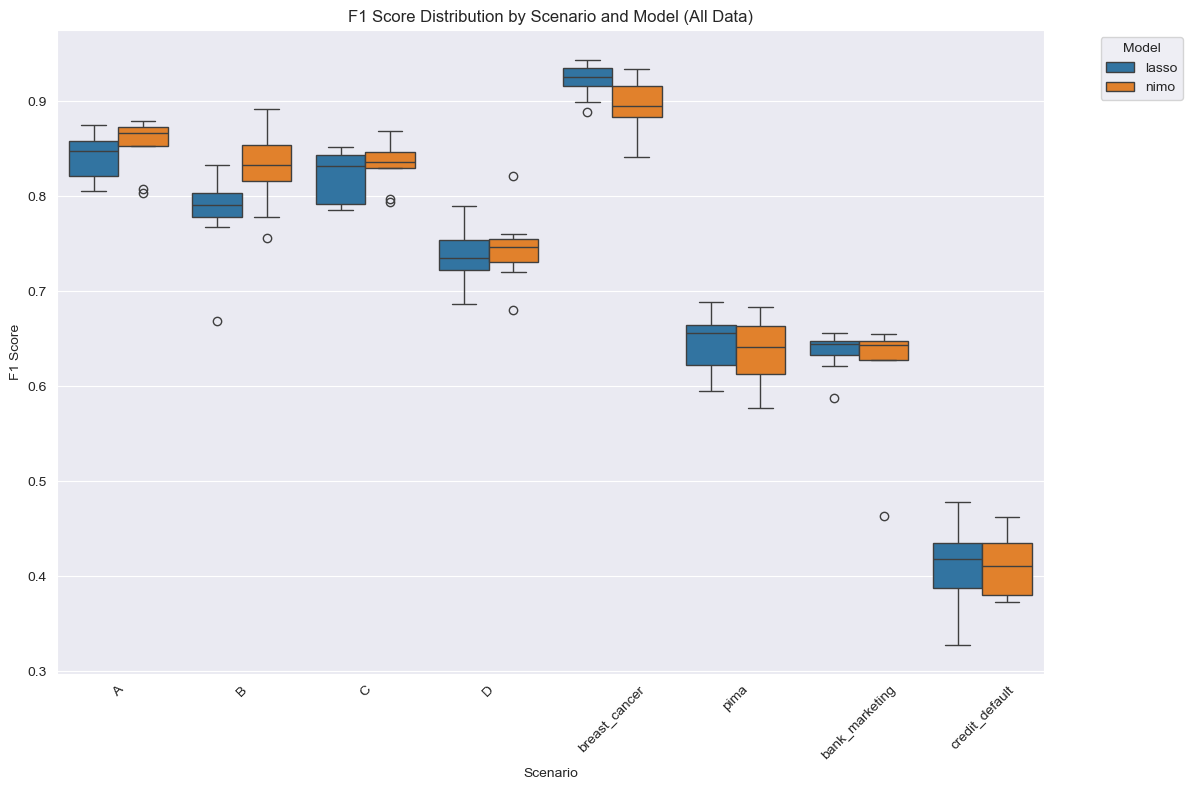

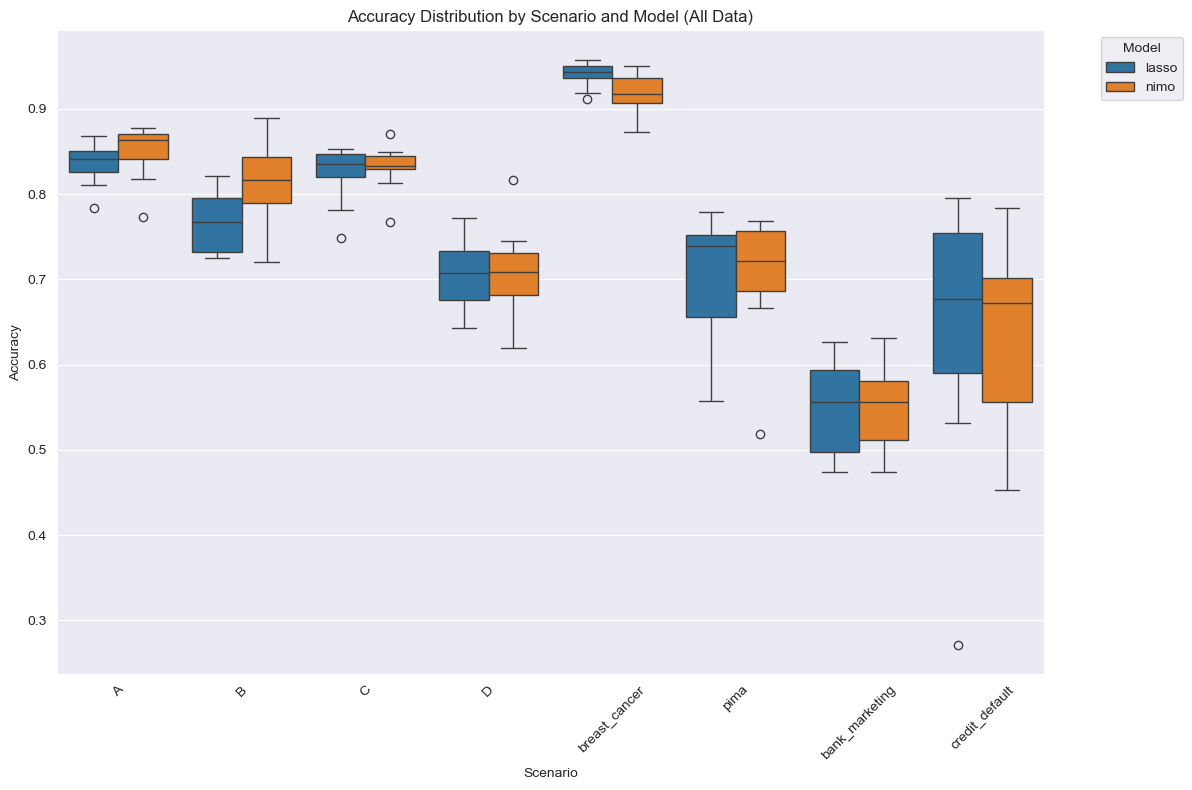

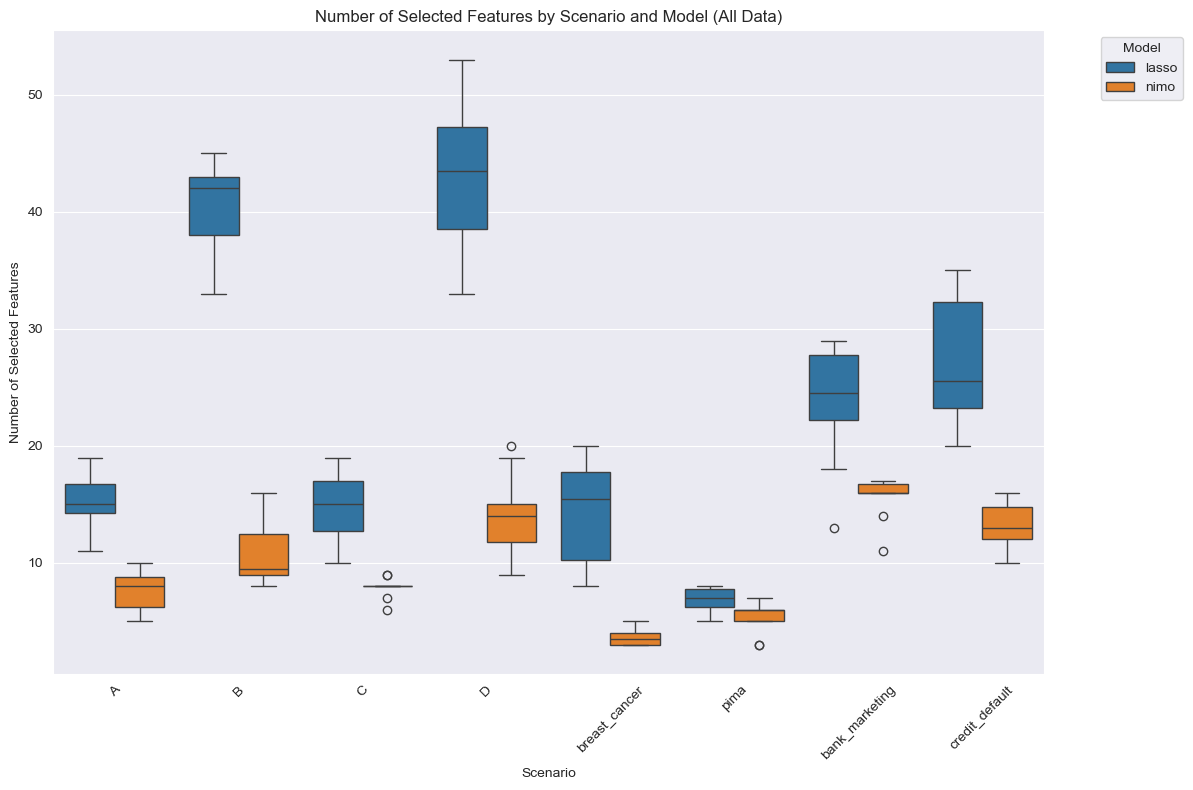


COEFFICIENT ANALYSIS


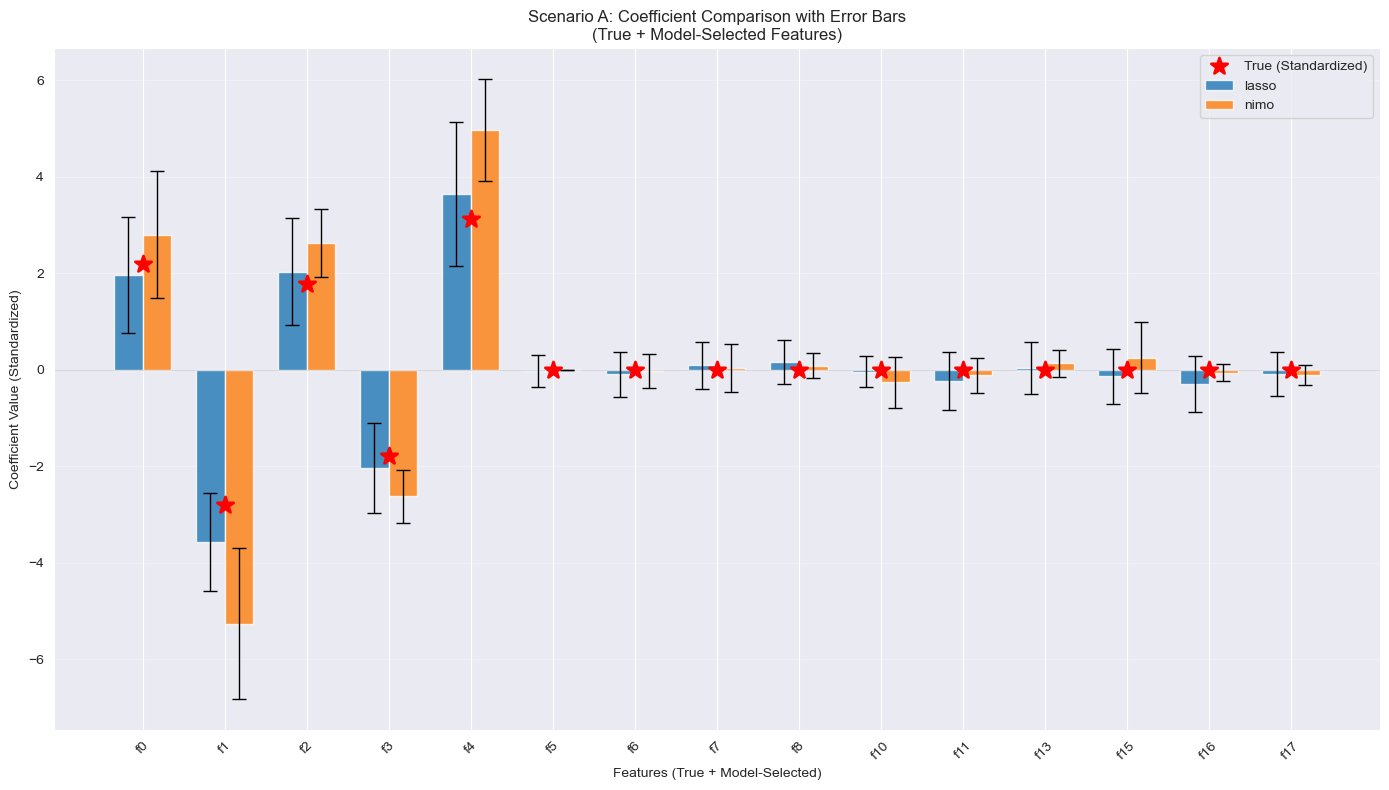


SCENARIO A - DETAILED ANALYSIS
Features: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f10', 'f11', 'f13', 'f15', 'f16', 'f17']
True features: [0, 1, 2, 3, 4]
True beta values: ['2.000', '-3.000', '2.000', '-2.000', '3.000']
Mean |β| (true): 0.779

Best iterations:
  LASSO: Iteration 9 (F1: 0.875)
  NIMO: Iteration 3 (F1: 0.879)

--- MODEL PERFORMANCE ---

LASSO:
  Best iteration: 9 (F1: 0.875)
  Features selected (best): 14
  Features selected (avg): 15.4 ± 2.3
  F1 score (avg): 0.842 ± 0.024
  Mean |β|: 0.962 ± 0.705
  Max |β|: 3.634
  True features selected: 5/5
  False positives: 10/10

NIMO:
  Best iteration: 3 (F1: 0.879)
  Features selected (best): 8
  Features selected (avg): 7.7 ± 1.7
  F1 score (avg): 0.855 ± 0.027
  Mean |β|: 1.290 ± 0.572
  Max |β|: 5.261
  True features selected: 5/5
  False positives: 9/10



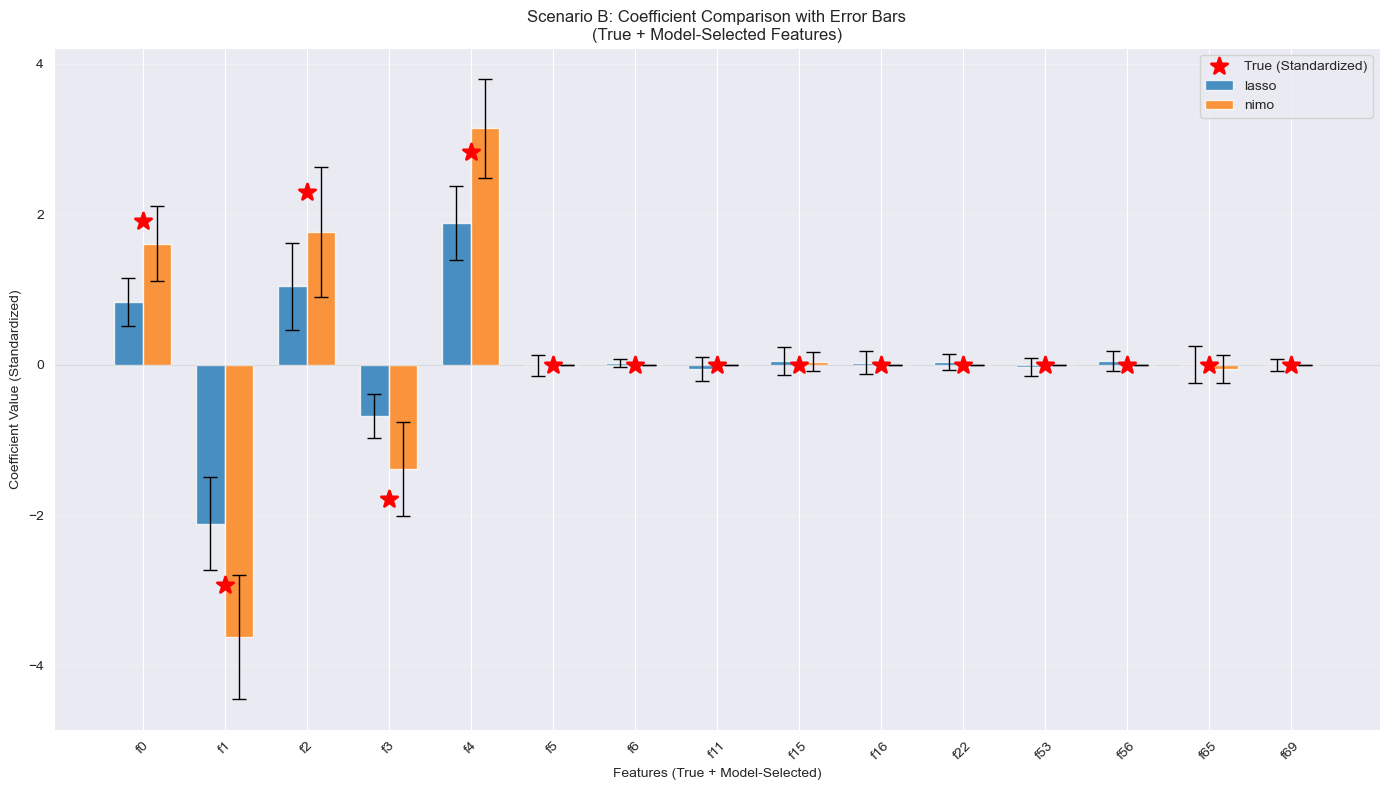


SCENARIO B - DETAILED ANALYSIS
Features: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f11', 'f15', 'f16', 'f22', 'f53', 'f56', 'f65', 'f69']
True features: [0, 1, 2, 3, 4]
True beta values: ['2.000', '-3.000', '2.000', '-2.000', '3.000']
Mean |β| (true): 0.784

Best iterations:
  LASSO: Iteration 8 (F1: 0.833)
  NIMO: Iteration 8 (F1: 0.891)

--- MODEL PERFORMANCE ---

LASSO:
  Best iteration: 8 (F1: 0.833)
  Features selected (best): 38
  Features selected (avg): 40.6 ± 3.7
  F1 score (avg): 0.782 ± 0.044
  Mean |β|: 0.457 ± 0.246
  Max |β|: 2.117
  True features selected: 5/5
  False positives: 10/10

NIMO:
  Best iteration: 8 (F1: 0.891)
  Features selected (best): 9
  Features selected (avg): 10.8 ± 2.7
  F1 score (avg): 0.829 ± 0.040
  Mean |β|: 0.775 ± 0.252
  Max |β|: 3.623
  True features selected: 5/5
  False positives: 2/10



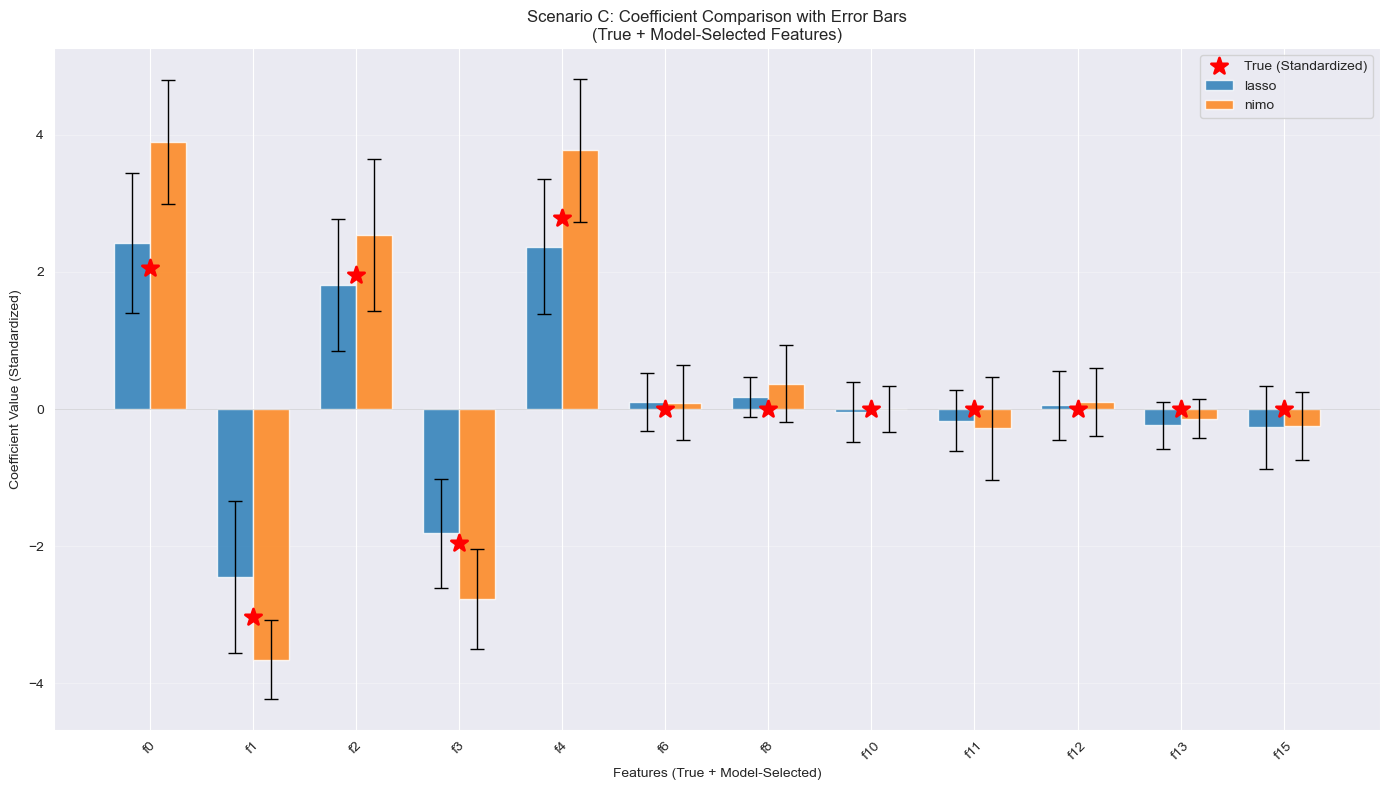


SCENARIO C - DETAILED ANALYSIS
Features: ['f0', 'f1', 'f2', 'f3', 'f4', 'f6', 'f8', 'f10', 'f11', 'f12', 'f13', 'f15']
True features: [0, 1, 2, 3, 4]
True beta values: ['2.000', '-3.000', '2.000', '-2.000', '3.000']
Mean |β| (true): 0.984

Best iterations:
  LASSO: Iteration 2 (F1: 0.851)
  NIMO: Iteration 9 (F1: 0.869)

--- MODEL PERFORMANCE ---

LASSO:
  Best iteration: 2 (F1: 0.851)
  Features selected (best): 10
  Features selected (avg): 14.9 ± 2.8
  F1 score (avg): 0.821 ± 0.027
  Mean |β|: 0.993 ± 0.661
  Max |β|: 2.457
  True features selected: 5/5
  False positives: 7/7

NIMO:
  Best iteration: 9 (F1: 0.869)
  Features selected (best): 8
  Features selected (avg): 7.9 ± 0.9
  F1 score (avg): 0.833 ± 0.023
  Mean |β|: 1.487 ± 0.653
  Max |β|: 3.896
  True features selected: 5/5
  False positives: 7/7



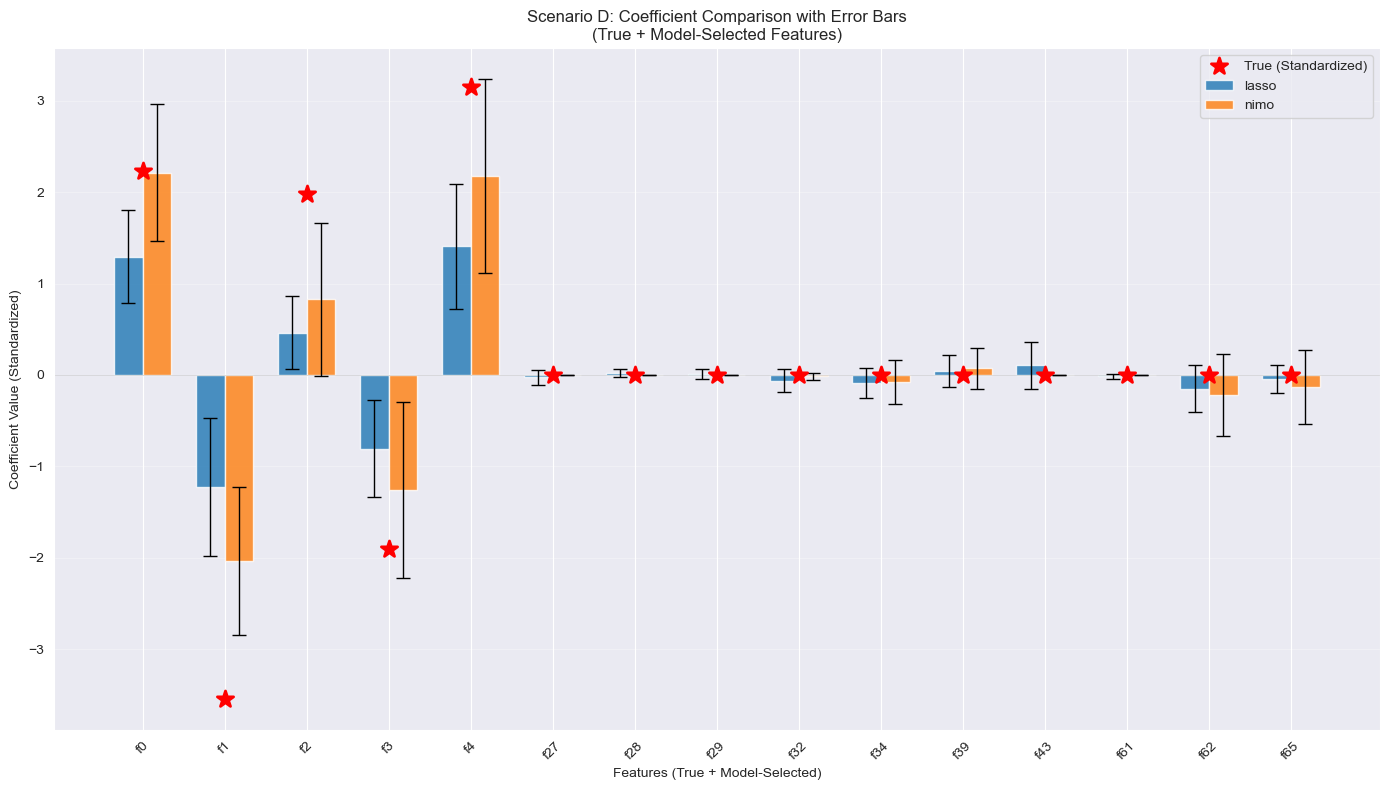


SCENARIO D - DETAILED ANALYSIS
Features: ['f0', 'f1', 'f2', 'f3', 'f4', 'f27', 'f28', 'f29', 'f32', 'f34', 'f39', 'f43', 'f61', 'f62', 'f65']
True features: [0, 1, 2, 3, 4]
True beta values: ['2.000', '-3.000', '2.000', '-2.000', '3.000']
Mean |β| (true): 0.855

Best iterations:
  LASSO: Iteration 9 (F1: 0.790)
  NIMO: Iteration 9 (F1: 0.821)

--- MODEL PERFORMANCE ---

LASSO:
  Best iteration: 9 (F1: 0.790)
  Features selected (best): 38
  Features selected (avg): 43.1 ± 6.0
  F1 score (avg): 0.737 ± 0.031
  Mean |β|: 0.385 ± 0.281
  Max |β|: 1.411
  True features selected: 5/5
  False positives: 10/10

NIMO:
  Best iteration: 9 (F1: 0.821)
  Features selected (best): 11
  Features selected (avg): 14.1 ± 3.5
  F1 score (avg): 0.746 ± 0.036
  Mean |β|: 0.603 ± 0.386
  Max |β|: 2.216
  True features selected: 5/5
  False positives: 5/10


REAL DATASET COEFFICIENT ANALYSIS (NO GROUND TRUTH)

--- BREAST_CANCER ---
lasso: 30 total features, showing top 15
nimo: 30 total features, showing 

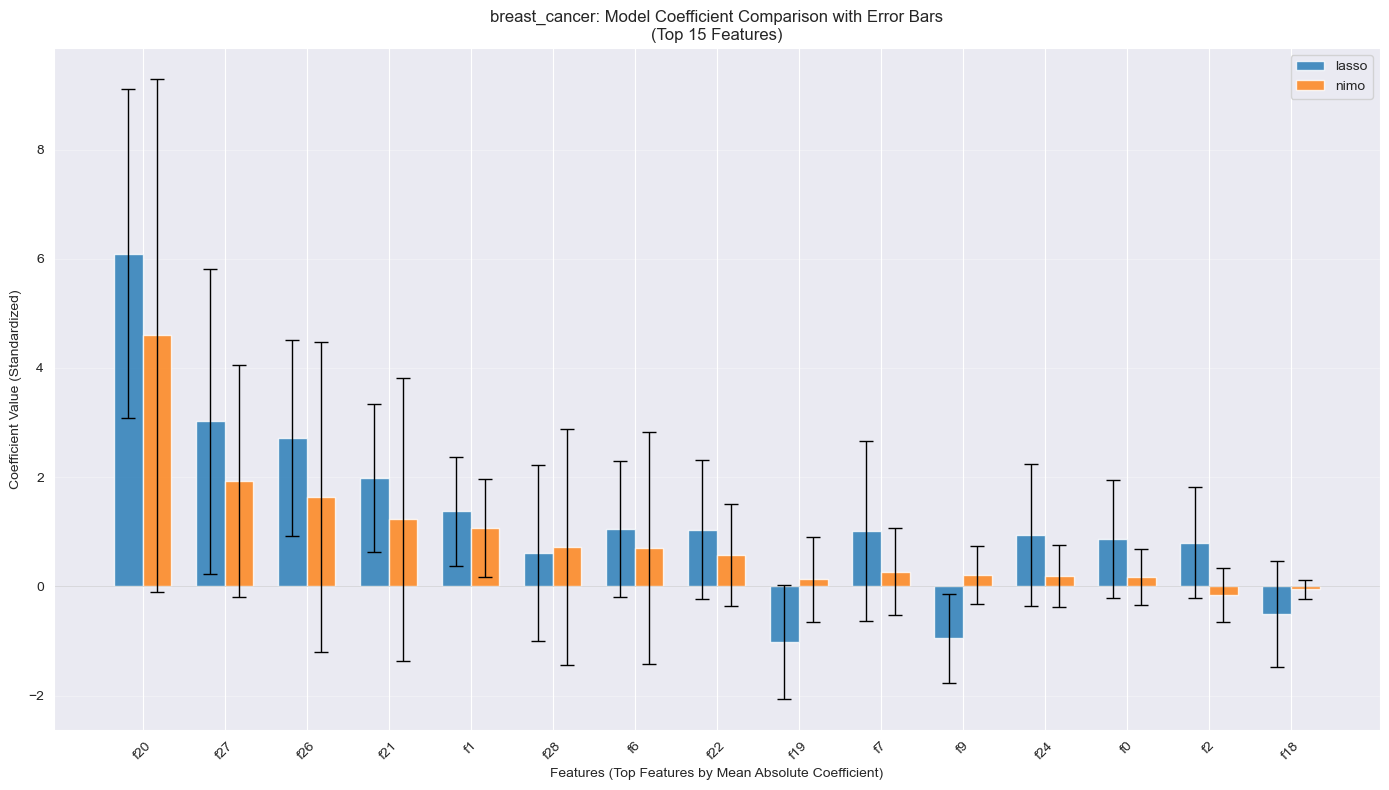

Coefficient Statistics:
  lasso: Mean |β| = 1.601 ± 1.464
  nimo: Mean |β| = 0.910 ± 1.482

--- PIMA ---
lasso: 8 total features, showing top 8
nimo: 8 total features, showing top 8


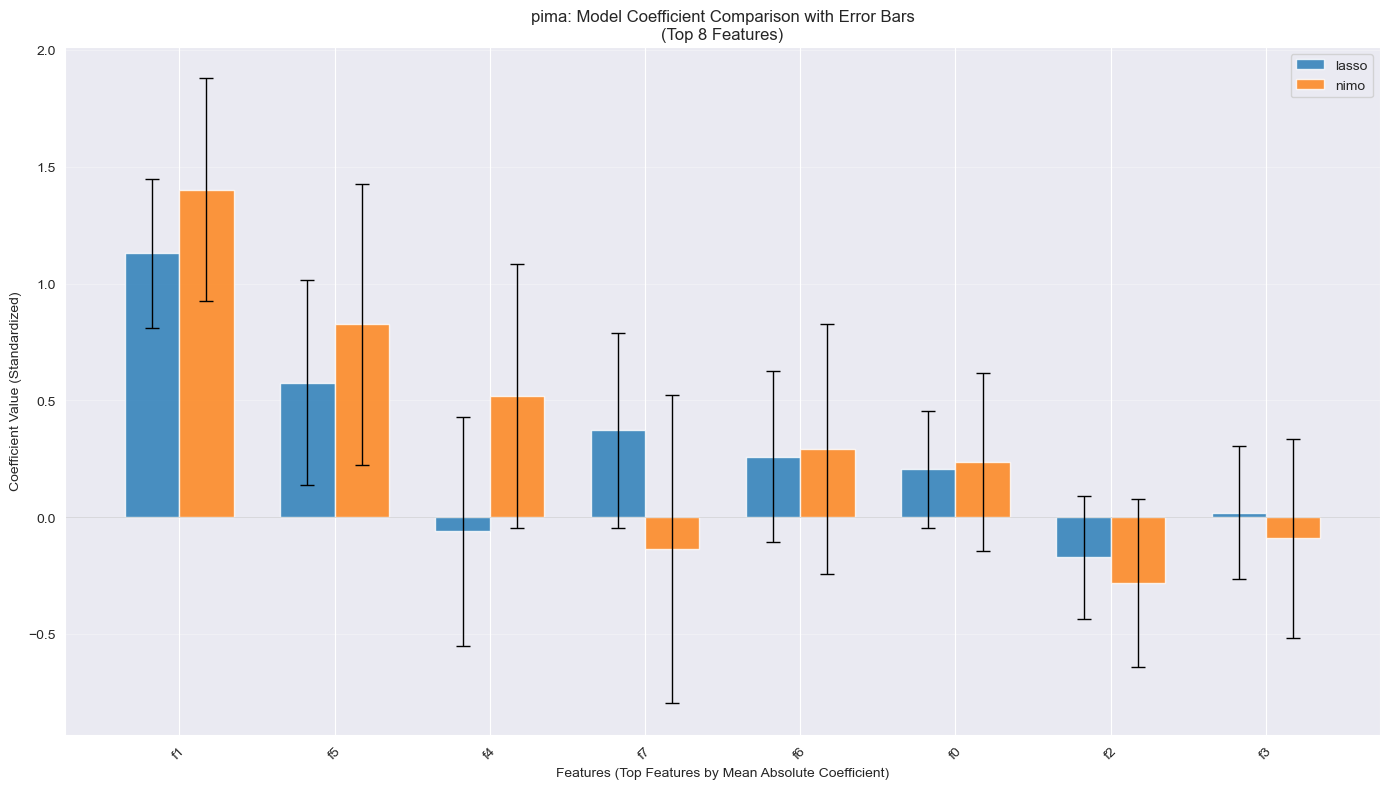

Coefficient Statistics:
  lasso: Mean |β| = 0.349 ± 0.354
  nimo: Mean |β| = 0.473 ± 0.501

SUMMARY STATISTICS

Scenario A:
                f1         accuracy         n_selected        
              mean     std     mean     std       mean     std
model_name                                                    
lasso       0.8421  0.0241   0.8360  0.0250       15.4  2.2706
nimo        0.8549  0.0274   0.8493  0.0324        7.7  1.7029

Scenario B:
                f1         accuracy         n_selected        
              mean     std     mean     std       mean     std
model_name                                                    
lasso       0.7822  0.0439   0.7670  0.0376       40.6  3.7178
nimo        0.8292  0.0404   0.8136  0.0520       10.8  2.6583

Scenario C:
                f1         accuracy         n_selected        
              mean     std     mean     std       mean     std
model_name                                                    
lasso       0.8211  0.0270   0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the unified pipeline results
df = pd.read_csv('../../results/all/experiment_results.csv')

# Data preparation
df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
df['accuracy'] = pd.to_numeric(df['accuracy'], errors='coerce')
df['n_selected'] = pd.to_numeric(df['n_selected'], errors='coerce')

print(f"DataFrame shape: {df.shape}")
print(f"Available columns: {df.columns.tolist()}")
print()

# Define models and colors
MODELS = df['model_name'].unique().tolist()
PALETTE = {model: f'C{i}' for i, model in enumerate(MODELS)}

print(f"Models: {MODELS}")

# Separate synthetic and real datasets
df_synthetic = df[df['data_type'] == 'synthetic'].copy()
df_real = df[df['data_type'] == 'real'].copy()

print(f"Synthetic datasets: {df_synthetic.shape[0]} rows")
print(f"Real datasets: {df_real.shape[0]} rows")

# Scenario order (synthetic first, then real)
scenario_order = ['A', 'B', 'C', 'D', 'breast_cancer', 'pima', 'bank_marketing', 'credit_default', 'spambase']
scenario_order = [s for s in scenario_order if s in df['scenario'].unique()]

print(f"Scenarios: {scenario_order}")
print(f"Iterations: {df['iteration'].unique()}")
print()

# Scenario Analysis
print("=" * 80)
print("COMBINED DATASET ANALYSIS")
print("=" * 80)

for scen in scenario_order:
    scen_data = df[df['scenario'] == scen]
    desc = scen_data['scenario_description'].iloc[0]
    data_type = scen_data['data_type'].iloc[0]

    print(f"\nScenario {scen} ({data_type}): {desc}")
    print(f"  Iterations: {len(scen_data)}")

    # Parse true support and beta for synthetic data
    if data_type == 'synthetic':
        try:
            true_support = json.loads(scen_data['true_support'].iloc[0])
            beta_true = json.loads(scen_data['beta_true'].iloc[0])
            print(f"  True support: {true_support}")
            print(f"  True beta (non-zero): {[beta_true[i] for i in range(len(beta_true))]}")
        except:
            print(f"  True support info not available")
    else:
        print(f"  Real dataset - no ground truth available")

# F1 Score Distribution
print("\n" + "=" * 80)
print("F1 SCORE DISTRIBUTION")
print("=" * 80)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='f1', hue='model_name', palette=PALETTE)
plt.title('F1 Score Distribution by Scenario and Model (All Data)')
plt.xlabel('Scenario')
plt.ylabel('F1 Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accuracy Distribution
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='accuracy', hue='model_name', palette=PALETTE)
plt.title('Accuracy Distribution by Scenario and Model (All Data)')
plt.xlabel('Scenario')
plt.ylabel('Accuracy')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Number of Selected Features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='n_selected', hue='model_name', palette=PALETTE)
plt.title('Number of Selected Features by Scenario and Model (All Data)')
plt.xlabel('Scenario')
plt.ylabel('Number of Selected Features')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Helper function to convert raw beta to standardized space
def raw_to_std(beta_raw, b0_raw, mu, s, true_support=None):
    """Convert raw beta to standardized space for comparison."""
    beta_raw = np.asarray(beta_raw, float)
    mu = np.asarray(mu, float)
    s = np.asarray(s, float)
    
    # If true_support is provided, we need to map the beta values to the full feature space
    if true_support is not None and len(beta_raw) < len(mu):
        # Create full beta vector with zeros for non-true features
        beta_full = np.zeros(len(mu))
        beta_full[true_support] = beta_raw
        beta_raw = beta_full
    
    beta_std = s * beta_raw                     # elementwise
    b0_std = b0_raw + float(np.dot(mu, beta_raw))
    return beta_std, b0_std

# Coefficient Analysis - Bar plots with error bars
print("\n" + "=" * 80)
print("COEFFICIENT ANALYSIS")
print("=" * 80)

TOPK = 15  # Number of top features to show

# Analyze synthetic datasets (with ground truth)
synthetic_scenarios = [s for s in scenario_order if s in df_synthetic['scenario'].unique()]

for scen in synthetic_scenarios:
    # Get the first row to extract true beta (same for all iterations in a scenario)
    row = df_synthetic[df_synthetic["scenario"] == scen].iloc[0]
    beta_true_raw = json.loads(row["beta_true"])
    true_support = json.loads(row["true_support"])
    b0_true_raw = 0.0  # Default intercept

    p = len(beta_true_raw)
    
    # Instead of just true importance, show features that are either:
    # 1. True features (important for ground truth comparison)
    # 2. Features selected by at least one model (important for model comparison)
    
    # Get features selected by any model
    model_selected_features = set()
    for m in MODELS:
        sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
        if len(sub) > 0:
            coefs_dict = json.loads(sub.iloc[0]["coefficients"])
            coefs = coefs_dict.get("values", [])
            if coefs:
                non_zero_idx = np.where(np.array(coefs) != 0)[0]
                model_selected_features.update(non_zero_idx)
    
    # Combine true features with model-selected features
    all_important_features = set(true_support) | model_selected_features
    all_important_features = sorted(list(all_important_features))
    
    # Take top features, prioritizing true features first
    true_features_first = true_support + [f for f in all_important_features if f not in true_support]
    top_idx = true_features_first[:min(TOPK, len(true_features_first))]
    
    labels = [f"f{j}" for j in top_idx]

    # Collect coefficients from ALL iterations for error bar calculation
    all_coefs = {model: [] for model in MODELS}
    beta_true_std = None  # Will be computed once using the first model's scaler
    b0_true_std = None

    for m in MODELS:
        sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
        if len(sub) == 0:
            continue
            
        for _, model_row in sub.iterrows():
            try:
                coefs_dict = json.loads(model_row["coefficients"])
                coefs = coefs_dict.get("values", [])
                mu = coefs_dict.get("mean", np.zeros(p))
                s = coefs_dict.get("scale", np.ones(p))
                
                # Convert true beta to standardized space using this model's scaler
                if beta_true_std is None:
                    beta_true_std, b0_true_std = raw_to_std(beta_true_raw, b0_true_raw, mu, s, true_support)

                if coefs and len(coefs) == len(mu):
                    coefs_array = np.array(coefs)[top_idx]
                    all_coefs[m].append(coefs_array)
                    
            except Exception as e:
                print(f"Warning: Could not parse coefficients for {m}: {e}")
                continue

    # Calculate means and standard errors for each model
    model_means = {}
    model_stds = {}
    
    for m in MODELS:
        if len(all_coefs[m]) > 0:
            coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
            model_means[m] = np.mean(coefs_matrix, axis=0)
            model_stds[m] = np.std(coefs_matrix, axis=0)
        else:
            print(f"Warning: No valid coefficients for {m} in scenario {scen}")

    # Plot coefficient comparison if we have valid data
    if beta_true_std is not None and len(model_means) > 0:
        plt.figure(figsize=(14, 8))
        
        x = np.arange(len(labels))
        width = 0.35  # Width of bars
        
        # True coefficients (standardized) - as horizontal line
        beta_true_top = beta_true_std[top_idx]
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Plot bars for each model
        for i, (model, means) in enumerate(model_means.items()):
            stds = model_stds[model]
            x_pos = x + i * width - width/2  # Offset bars
            bars = plt.bar(x_pos, means, width, 
                          label=f'{model}', 
                          color=PALETTE[model], 
                          alpha=0.8,
                          yerr=stds, 
                          capsize=5,
                          error_kw={'elinewidth': 1, 'capthick': 1})
        
        # Add true coefficients as red stars
        plt.scatter(x, beta_true_top, 
                   color='red', s=150, marker='*', 
                   label='True (Standardized)', zorder=10, linewidth=2)
        
        plt.xlabel('Features (True + Model-Selected)')
        plt.ylabel('Coefficient Value (Standardized)')
        plt.title(f'Scenario {scen}: Coefficient Comparison with Error Bars\n(True + Model-Selected Features)')
        plt.xticks(x, labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # Find best iteration for each model
        best_iterations = {}
        for m in MODELS:
            sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
            if len(sub) > 0:
                f1_scores = sub['f1'].dropna()
                if len(f1_scores) > 0:
                    best_idx = f1_scores.idxmax()
                    best_iterations[m] = sub.loc[best_idx]
                else:
                    best_iterations[m] = sub.iloc[0]  # Fallback to first iteration
        
        # Print detailed summary statistics
        print(f"\n" + "="*60)
        print(f"SCENARIO {scen} - DETAILED ANALYSIS")
        print(f"="*60)
        
        print(f"Features: {labels}")
        print(f"True features: {true_support}")
        print(f"True beta values: {[f'{beta_true_raw[i]:.3f}' for i in true_support]}")
        print(f"Mean |β| (true): {np.mean(np.abs(beta_true_top)):.3f}")
        
        # Show which iterations had best performance
        print(f"\nBest iterations:")
        for m in MODELS:
            if m in best_iterations:
                best_iter = best_iterations[m]
                print(f"  {m.upper()}: Iteration {best_iter['iteration']} (F1: {best_iter['f1']:.3f})")
        
        print(f"\n--- MODEL PERFORMANCE ---")
        for m in MODELS:
            if m in model_means:
                # Get detailed info for this model
                sub = df_synthetic[(df_synthetic["scenario"] == scen) & (df_synthetic["model_name"] == m)]
                
                # Average features selected across all iterations
                n_selected_avg = sub['n_selected'].mean()
                n_selected_std = sub['n_selected'].std()
                
                # Performance metrics
                f1_avg = sub['f1'].mean()
                f1_std = sub['f1'].std()
                
                # Get best iteration info
                best_iter = best_iterations[m]
                best_iter_num = best_iter['iteration']
                best_f1 = best_iter['f1']
                best_n_selected = best_iter['n_selected']
                
                print(f"\n{m.upper()}:")
                print(f"  Best iteration: {best_iter_num} (F1: {best_f1:.3f})")
                print(f"  Features selected (best): {best_n_selected}")
                print(f"  Features selected (avg): {n_selected_avg:.1f} ± {n_selected_std:.1f}")
                print(f"  F1 score (avg): {f1_avg:.3f} ± {f1_std:.3f}")
                print(f"  Mean |β|: {np.mean(np.abs(model_means[m])):.3f} ± {np.mean(model_stds[m]):.3f}")
                print(f"  Max |β|: {np.max(np.abs(model_means[m])):.3f}")
                
                # Check how many true features were selected
                true_features_selected = sum(1 for i in true_support if i in top_idx and model_means[m][top_idx.index(i)] != 0)
                print(f"  True features selected: {true_features_selected}/{len(true_support)}")
                
                # Check false positives
                false_positives = sum(1 for i in top_idx if i not in true_support and model_means[m][top_idx.index(i)] != 0)
                print(f"  False positives: {false_positives}/{len(top_idx) - len(true_support)}")
        
        print(f"\n" + "="*60)
        
    else:
        print(f"No valid coefficient data for scenario {scen}")

# For real datasets, show coefficient comparison without ground truth
real_scenarios = [s for s in scenario_order if s in df_real['scenario'].unique()]

if real_scenarios:
    print("\n" + "=" * 80)
    print("REAL DATASET COEFFICIENT ANALYSIS (NO GROUND TRUTH)")
    print("=" * 80)
    
    for scen in real_scenarios[:2]:  # Show first 2 real datasets
        print(f"\n--- {scen.upper()} ---")
        
        # Collect coefficients from ALL iterations for error bar calculation
        all_coefs = {model: [] for model in MODELS}
        
        for m in MODELS:
            sub = df_real[(df_real["scenario"] == scen) & (df_real["model_name"] == m)]
            if len(sub) == 0:
                continue
                
            for _, model_row in sub.iterrows():
                try:
                    coefs_dict = json.loads(model_row["coefficients"])
                    coefs = coefs_dict.get("values", [])
                    
                    if coefs and len(coefs) > 0:
                        coefs_array = np.array(coefs)
                        all_coefs[m].append(coefs_array)
                        
                except Exception as e:
                    print(f"Warning: Could not parse coefficients for {m}: {e}")
                    continue

        # Calculate means and standard errors for each model
        model_means = {}
        model_stds = {}
        feature_labels = None
        
        for m in MODELS:
            if len(all_coefs[m]) > 0:
                coefs_matrix = np.array(all_coefs[m])  # Shape: (n_iterations, n_features)
                # Get top features by mean absolute coefficient value
                mean_abs_coefs = np.mean(np.abs(coefs_matrix), axis=0)
                top_idx = np.argsort(mean_abs_coefs)[::-1][:min(TOPK, len(mean_abs_coefs))]
                
                model_means[m] = np.mean(coefs_matrix[:, top_idx], axis=0)
                model_stds[m] = np.std(coefs_matrix[:, top_idx], axis=0)
                
                if feature_labels is None:
                    feature_labels = [f"f{i}" for i in top_idx]
                
                print(f"{m}: {coefs_matrix.shape[1]} total features, showing top {len(top_idx)}")
            else:
                print(f"Warning: No valid coefficients for {m} in dataset {scen}")

        # Plot coefficient comparison if we have valid data
        if len(model_means) > 0 and feature_labels is not None:
            plt.figure(figsize=(14, 8))
            
            x = np.arange(len(feature_labels))
            width = 0.35  # Width of bars
            
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
            
            # Plot bars for each model
            for i, (model, means) in enumerate(model_means.items()):
                stds = model_stds[model]
                x_pos = x + i * width - width/2  # Offset bars
                bars = plt.bar(x_pos, means, width, 
                              label=f'{model}', 
                              color=PALETTE[model], 
                              alpha=0.8,
                              yerr=stds, 
                              capsize=5,
                              error_kw={'elinewidth': 1, 'capthick': 1})
            
            plt.xlabel('Features (Top Features by Mean Absolute Coefficient)')
            plt.ylabel('Coefficient Value (Standardized)')
            plt.title(f'{scen}: Model Coefficient Comparison with Error Bars\n(Top {len(feature_labels)} Features)')
            plt.xticks(x, feature_labels, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"Coefficient Statistics:")
            for m in MODELS:
                if m in model_means:
                    print(f"  {m}: Mean |β| = {np.mean(np.abs(model_means[m])):.3f} ± {np.mean(model_stds[m]):.3f}")
            
        else:
            print(f"No valid coefficient data for dataset {scen}")

# Summary Statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

for scen in scenario_order:
    print(f"\nScenario {scen}:")
    scen_summary = df[df['scenario'] == scen].groupby('model_name').agg({
        'f1': ['mean', 'std'],
        'accuracy': ['mean', 'std'],
        'n_selected': ['mean', 'std']
    }).round(4)
    print(scen_summary)

print("\n" + "=" * 80)
print("COMBINED ANALYSIS COMPLETE")
print("=" * 80)


DataFrame shape: (160, 33)
Available columns: ['model_name', 'iteration', 'random_seed', 'f1', 'accuracy', 'threshold', 'y_prob', 'y_pred', 'coefficients', 'n_selected', 'selection', 'hyperparams', 'training_time', 'data_type', 'dataset_id', 'dataset_description', 'n_features_total', 'n_test_samples', 'n_pool_samples', 'scenario', 'scenario_description', 'scenario_title', 'n_true_features', 'true_support', 'beta_true', 'decomposition_val', 'decomposition_test', 'correction_stats_val', 'no_harm_val', 'training', 'selected_features', 'best_f1', 'best_threshold']

Models: ['lasso', 'nimo']
Synthetic datasets: 80 rows
Real datasets: 80 rows
Scenarios: ['A', 'B', 'C', 'D', 'breast_cancer', 'pima', 'bank_marketing', 'credit_default']
Iterations: [0 1 2 3 4 5 6 7 8 9]

COMBINED DATASET ANALYSIS

Scenario A (synthetic): Linear (low-dim, 20 features)
  Iterations: 20
  True support: [0, 1, 2, 3, 4]
  True beta (non-zero): [2.0, -3.0, 2.0, -2.0, 3.0]

Scenario B (synthetic): Linear (high-dim, 20

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_41756/1556009871.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')


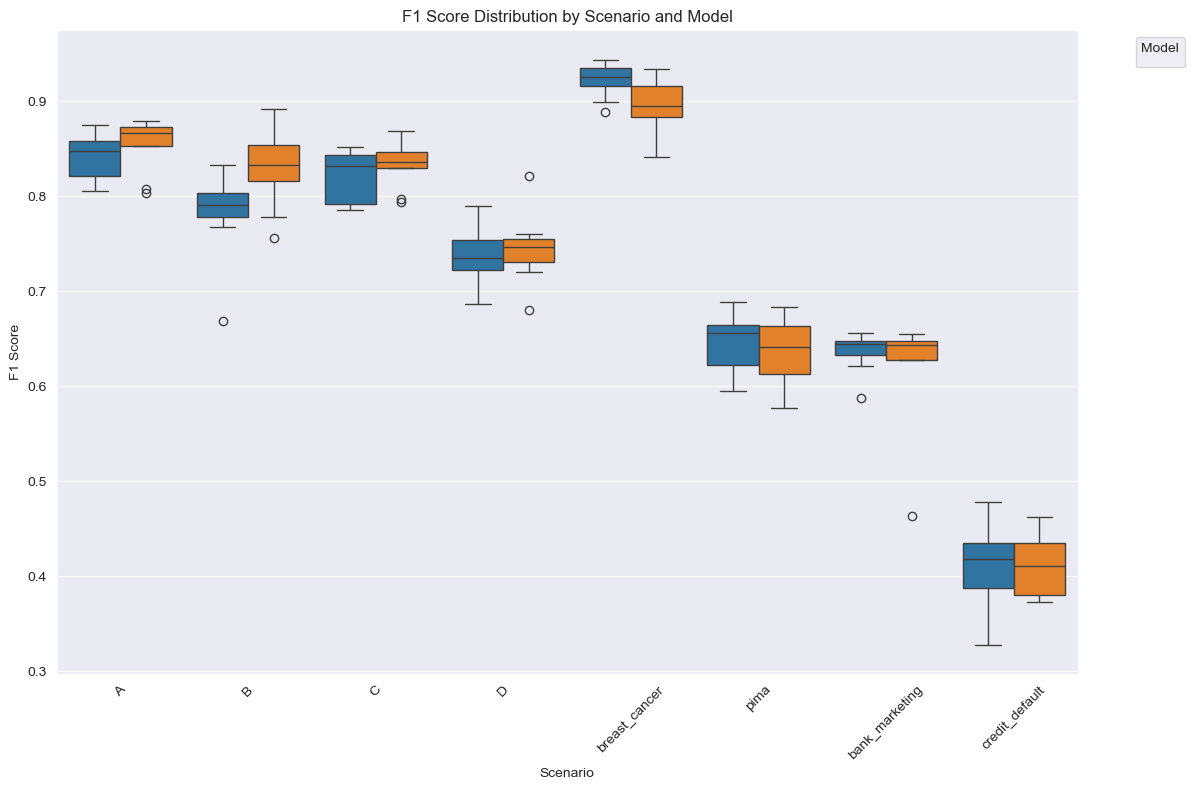

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_41756/1556009871.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')


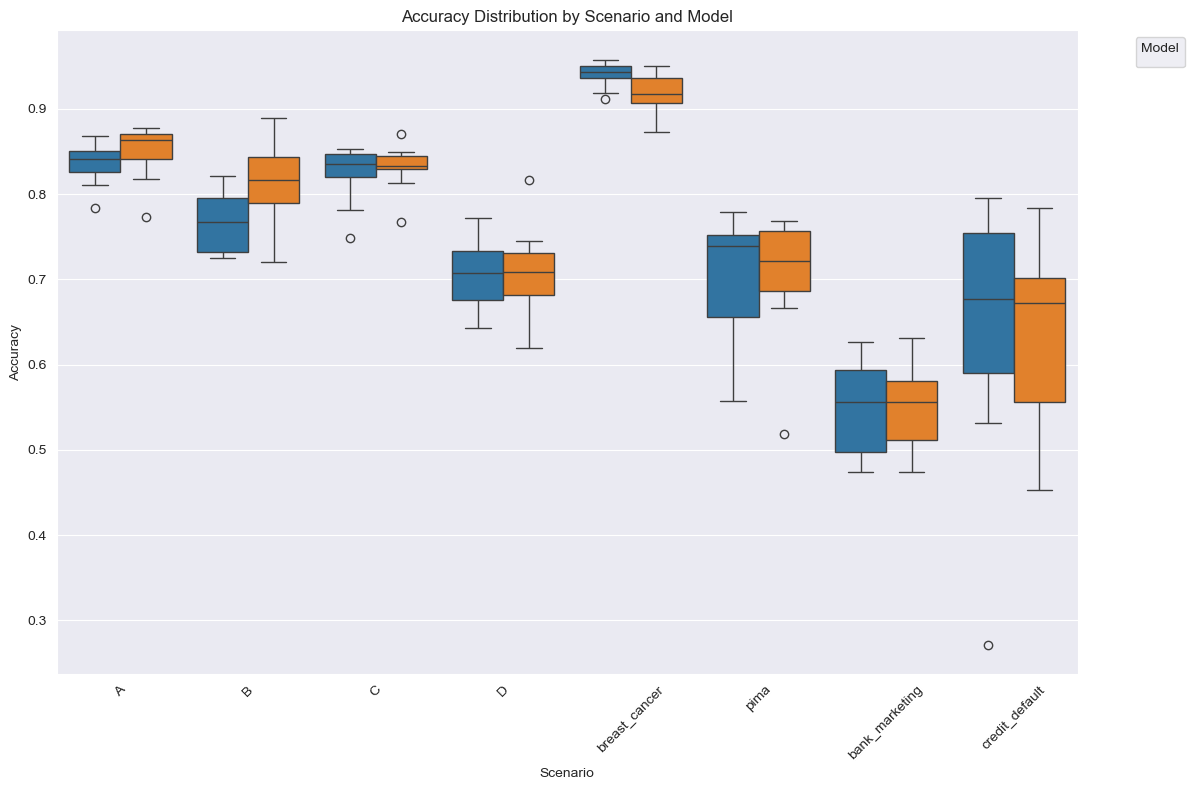

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_41756/1556009871.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')


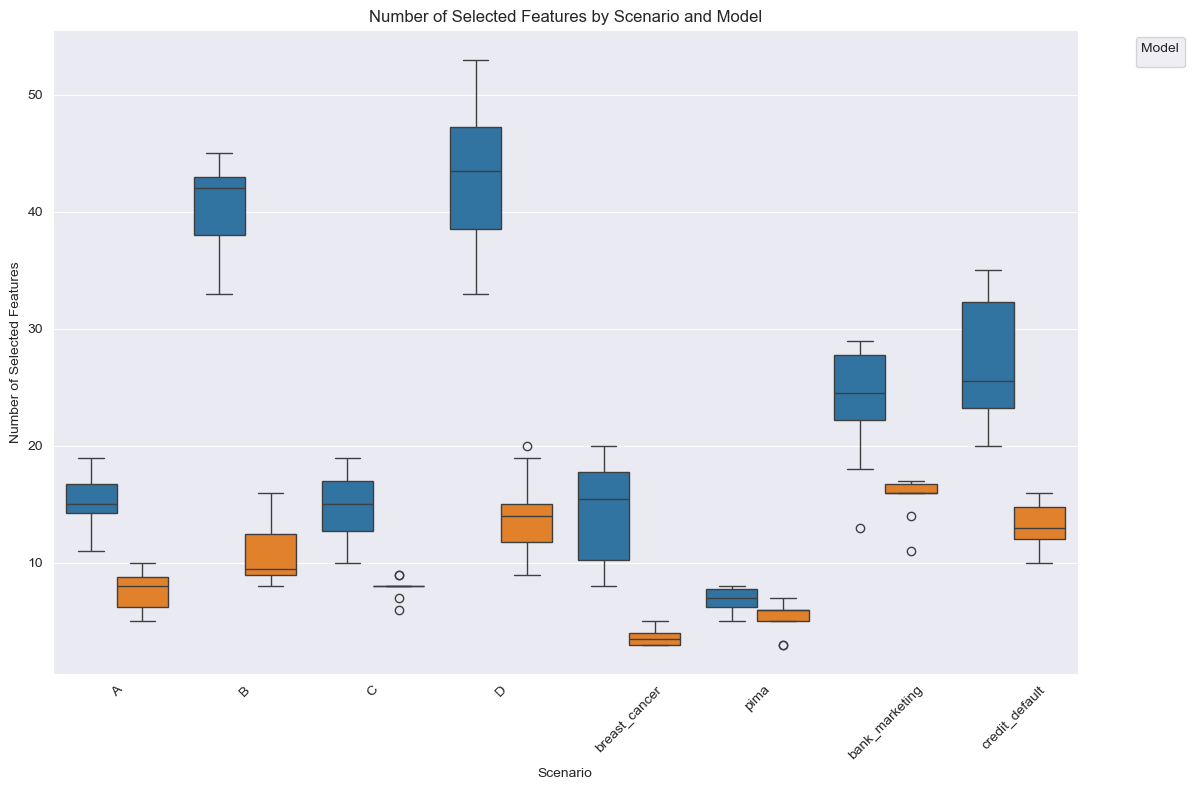

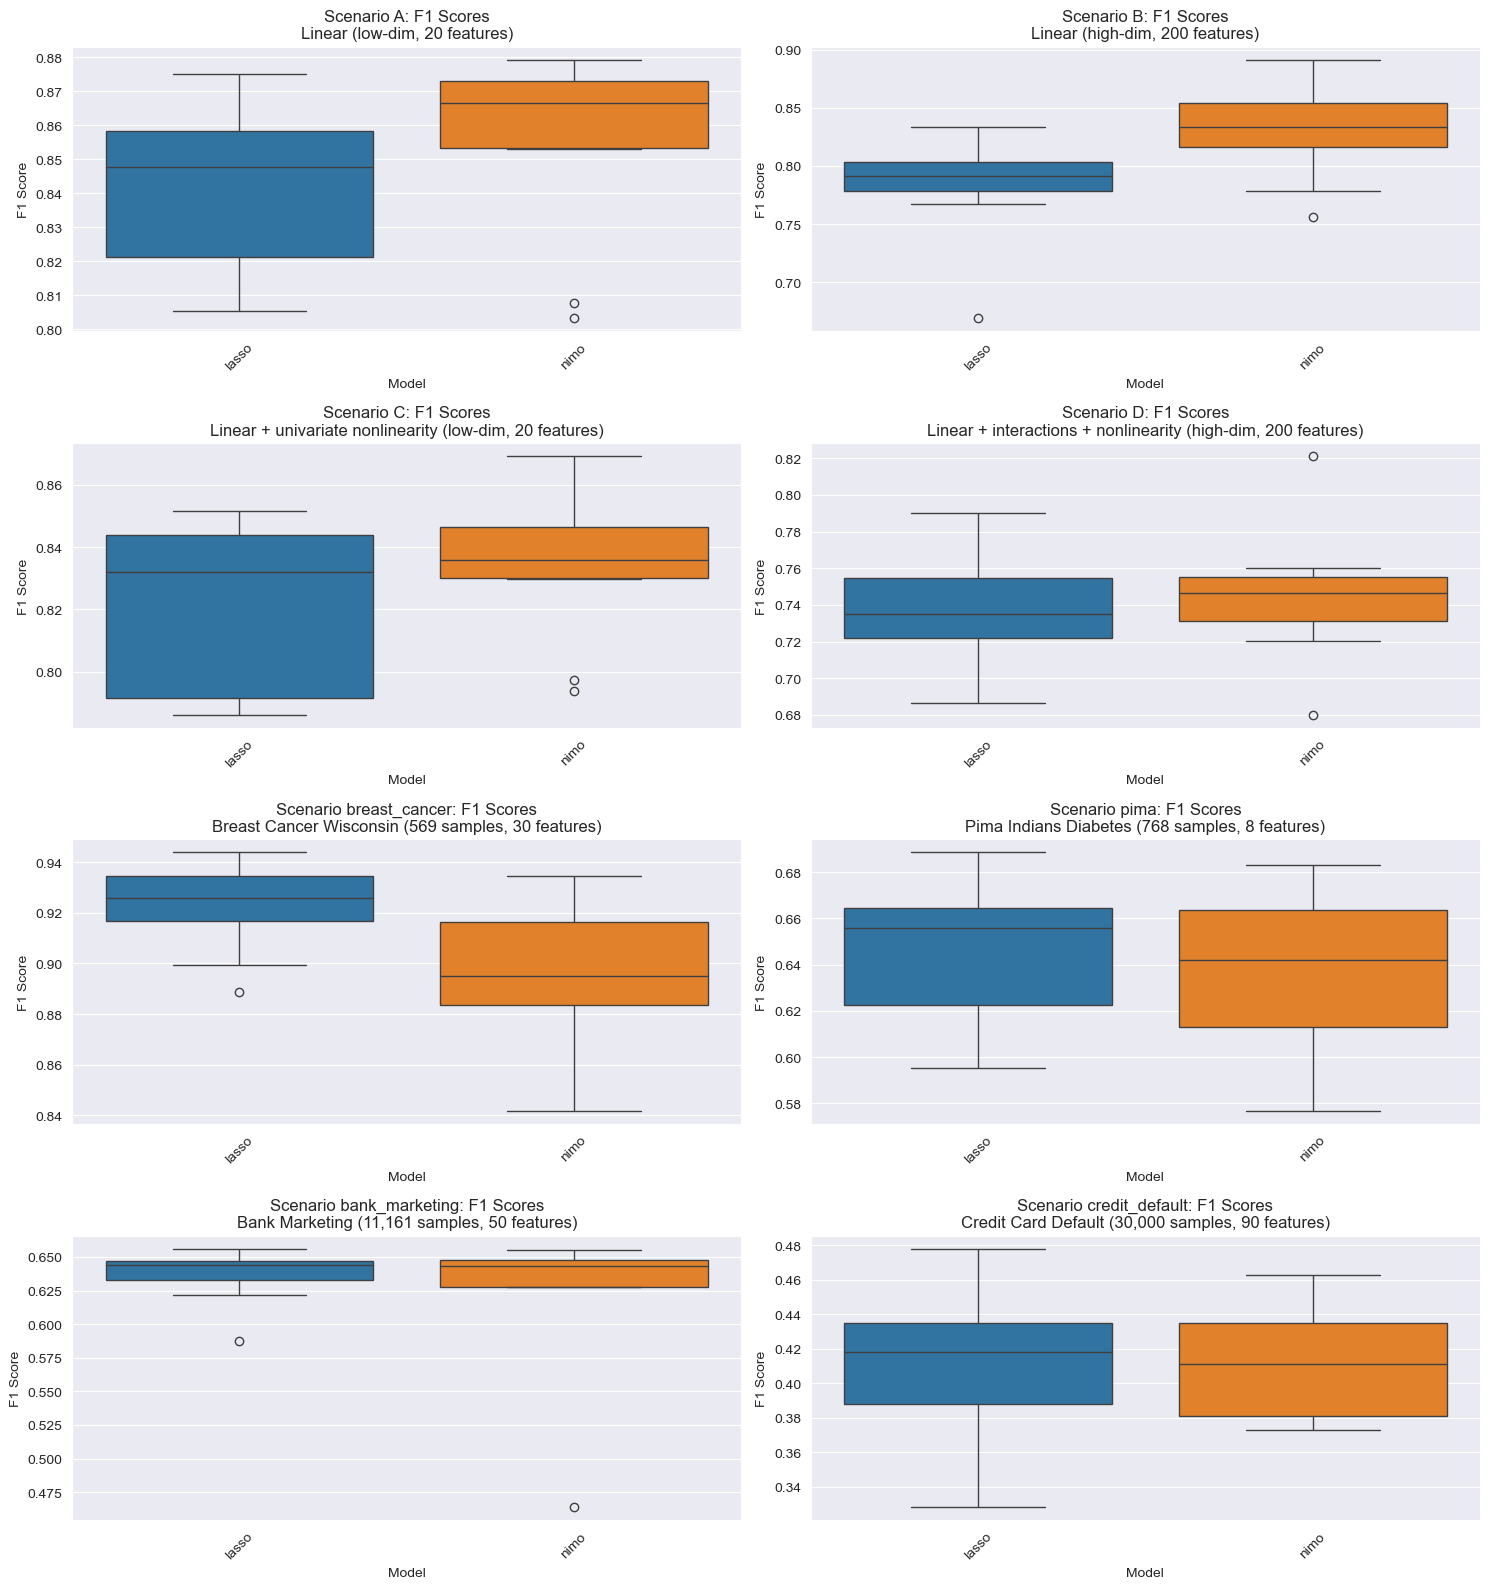

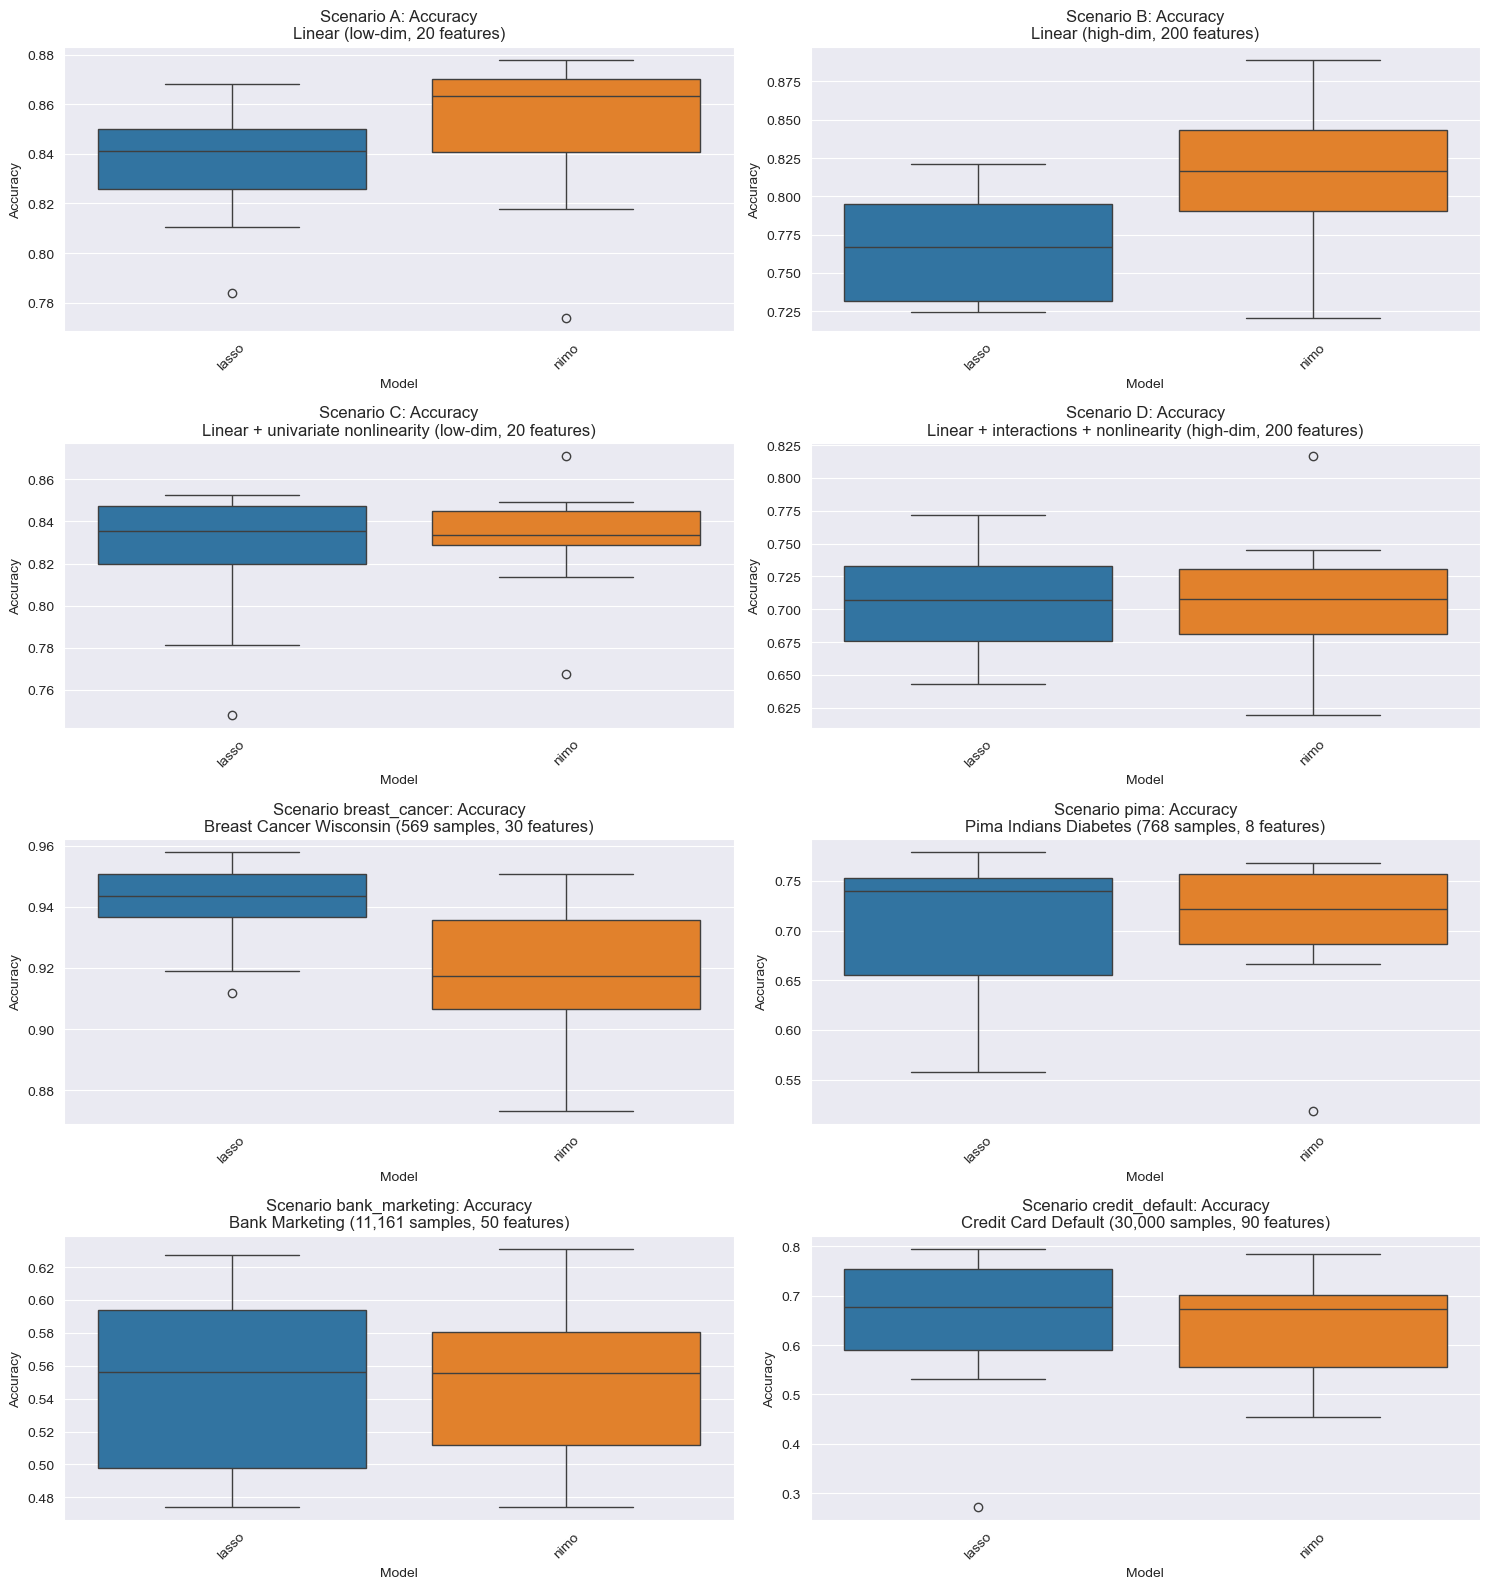


COEFFICIENT ANALYSIS (SYNTHETIC DATA ONLY)


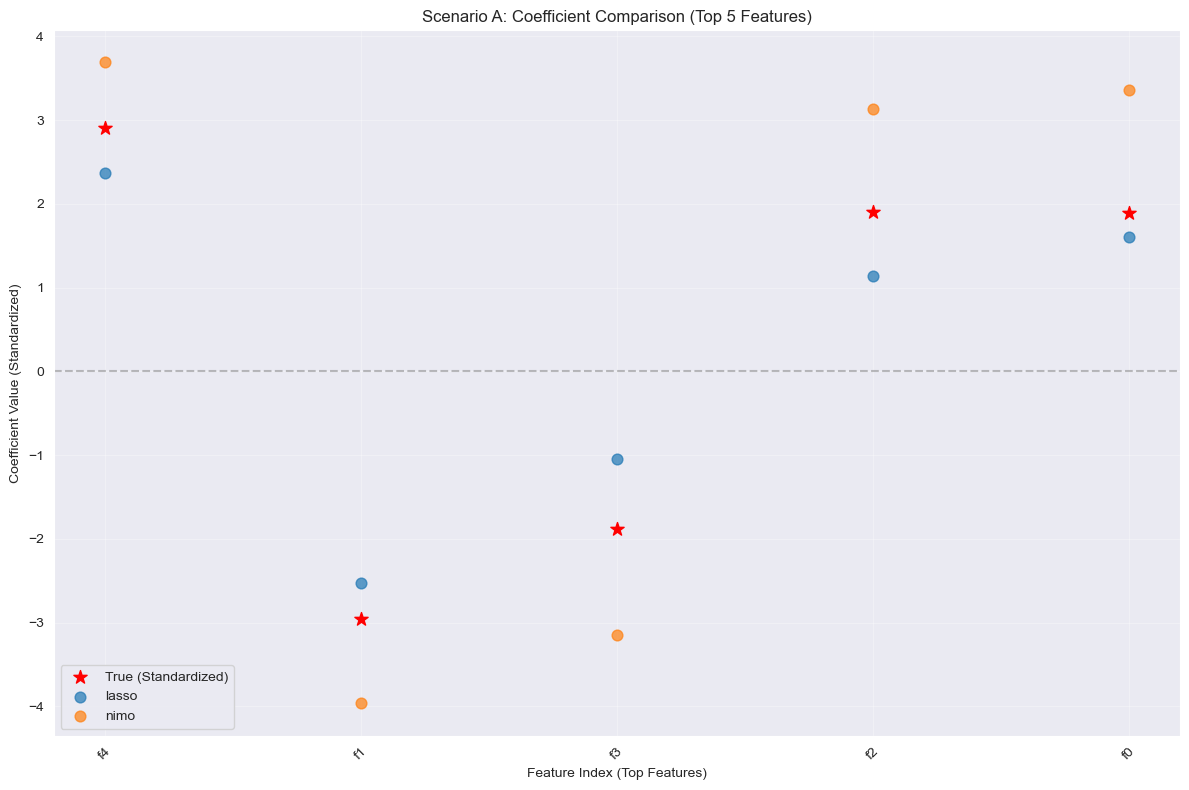

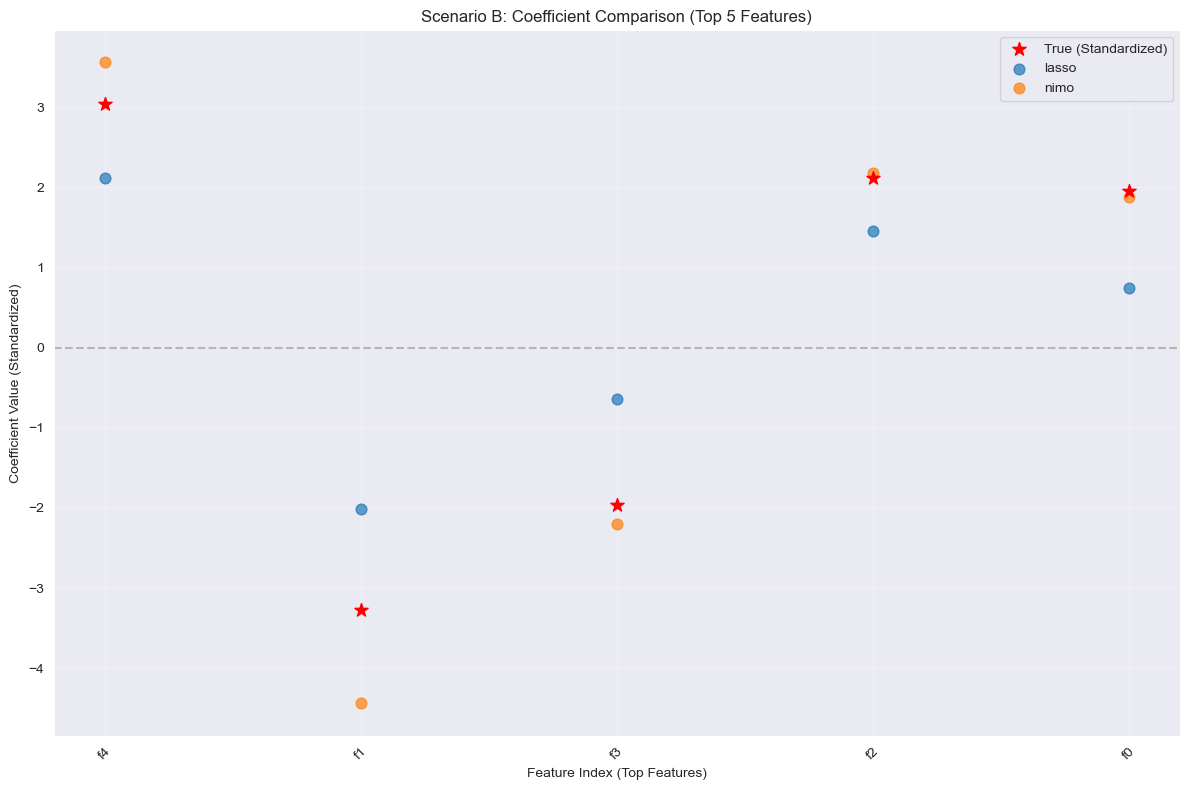

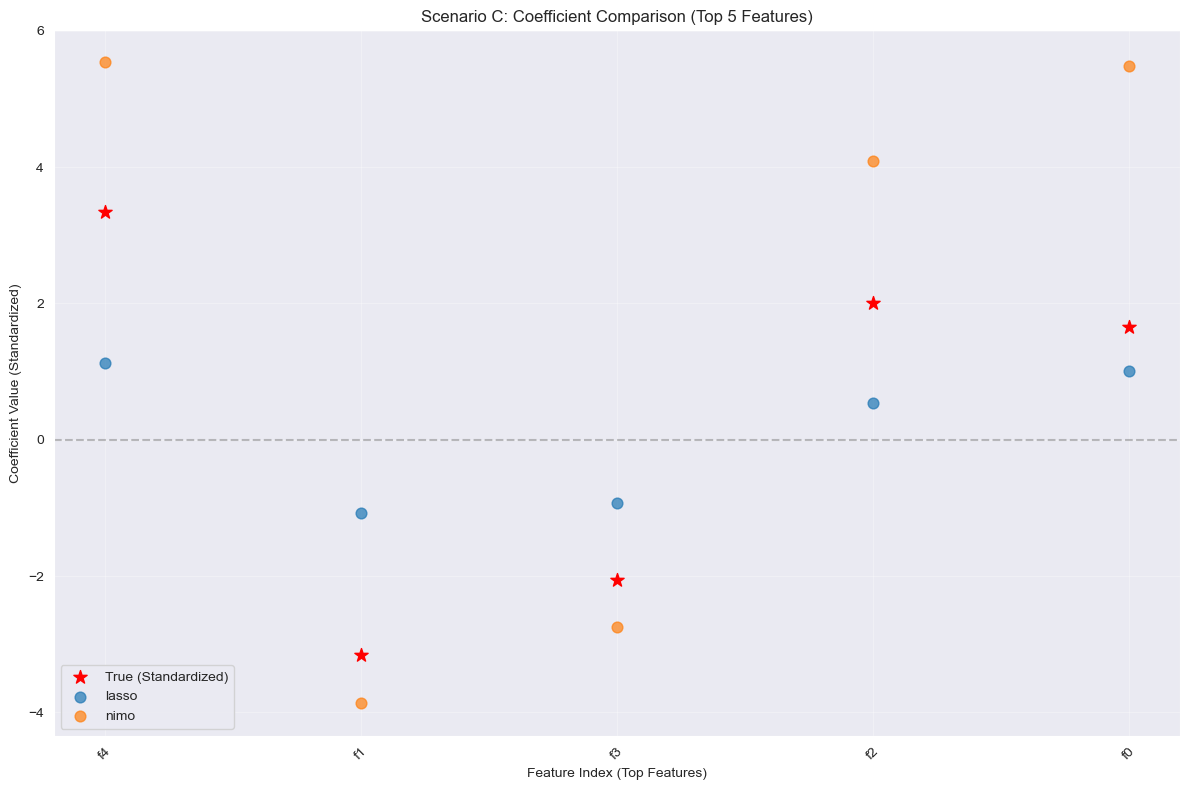

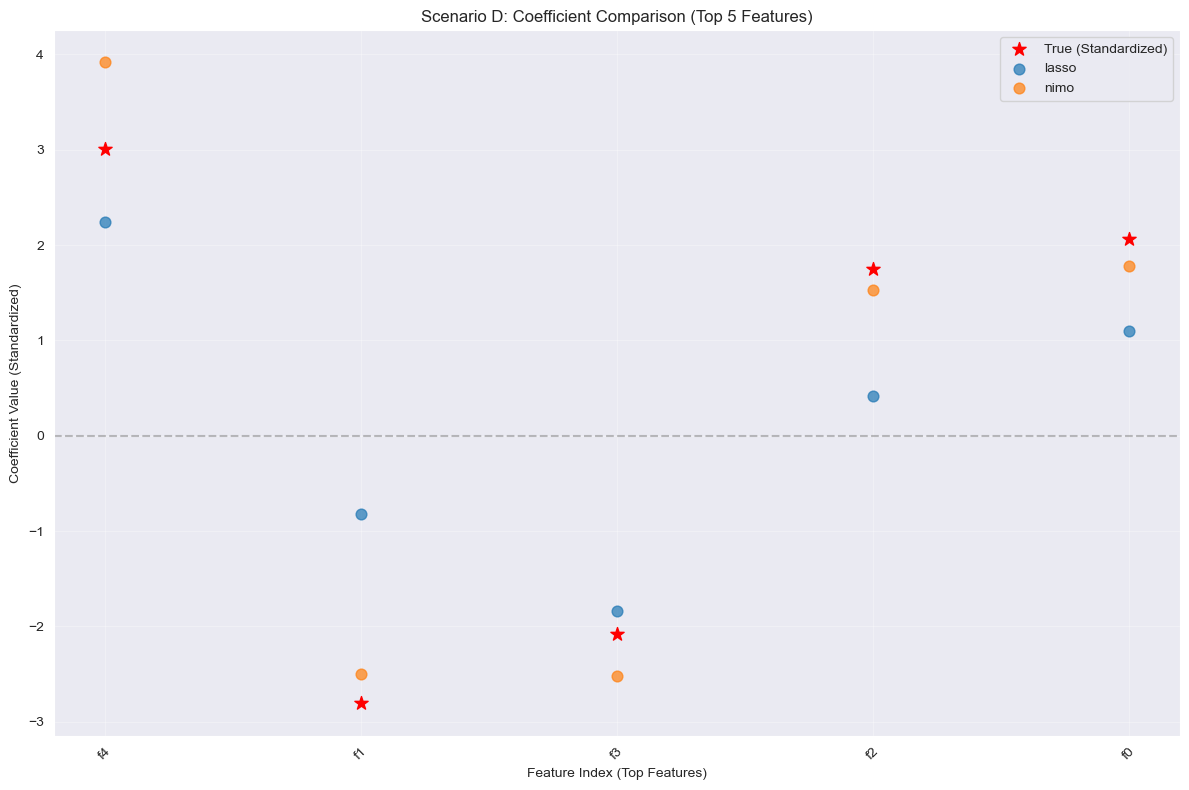

Skipping coefficient analysis for breast_cancer (real) - no ground truth available
Skipping coefficient analysis for pima (real) - no ground truth available
Skipping coefficient analysis for bank_marketing (real) - no ground truth available
Skipping coefficient analysis for credit_default (real) - no ground truth available

SUMMARY STATISTICS

Scenario A:
                f1         accuracy         n_selected        
              mean     std     mean     std       mean     std
model_name                                                    
lasso       0.8421  0.0241   0.8360  0.0250       15.4  2.2706
nimo        0.8549  0.0274   0.8493  0.0324        7.7  1.7029

Scenario B:
                f1         accuracy         n_selected        
              mean     std     mean     std       mean     std
model_name                                                    
lasso       0.7822  0.0439   0.7670  0.0376       40.6  3.7178
nimo        0.8292  0.0404   0.8136  0.0520       10.8  2.6583

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the unified pipeline results
df = pd.read_csv('../../results/all/experiment_results.csv')

# Data preparation
df['f1'] = pd.to_numeric(df['f1'], errors='coerce')
df['accuracy'] = pd.to_numeric(df['accuracy'], errors='coerce')
df['n_selected'] = pd.to_numeric(df['n_selected'], errors='coerce')

print(f"DataFrame shape: {df.shape}")
print(f"Available columns: {df.columns.tolist()}")
print()

# Define models and colors
MODELS = df['model_name'].unique().tolist()
PALETTE = {model: f'C{i}' for i, model in enumerate(MODELS)}

print(f"Models: {MODELS}")

# Separate synthetic and real datasets
df_synthetic = df[df['data_type'] == 'synthetic'].copy()
df_real = df[df['data_type'] == 'real'].copy()

print(f"Synthetic datasets: {df_synthetic.shape[0]} rows")
print(f"Real datasets: {df_real.shape[0]} rows")

# Scenario order (synthetic first, then real)
scenario_order = ['A', 'B', 'C', 'D', 'breast_cancer', 'pima', 'bank_marketing', 'credit_default', 'spambase']
scenario_order = [s for s in scenario_order if s in df['scenario'].unique()]

print(f"Scenarios: {scenario_order}")
print(f"Iterations: {df['iteration'].unique()}")
print()

# Scenario Analysis
print("=" * 80)
print("COMBINED DATASET ANALYSIS")
print("=" * 80)

for scen in scenario_order:
    scen_data = df[df['scenario'] == scen]
    desc = scen_data['scenario_description'].iloc[0]
    data_type = scen_data['data_type'].iloc[0]

    print(f"\nScenario {scen} ({data_type}): {desc}")
    print(f"  Iterations: {len(scen_data)}")

    # Parse true support and beta for synthetic data
    if data_type == 'synthetic':
        try:
            true_support = json.loads(scen_data['true_support'].iloc[0])
            beta_true = json.loads(scen_data['beta_true'].iloc[0])
            print(f"  True support: {true_support}")
            print(f"  True beta (non-zero): {[beta_true[i] for i in range(len(beta_true))]}")
        except:
            print(f"  True support info not available")
    else:
        print(f"  Real dataset - no ground truth available")

# F1 Score Distribution
print("\n" + "=" * 80)
print("F1 SCORE DISTRIBUTION")
print("=" * 80)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='f1', hue='model_name', palette=PALETTE, legend=False)
plt.title('F1 Score Distribution by Scenario and Model')
plt.xlabel('Scenario')
plt.ylabel('F1 Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accuracy Distribution
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='accuracy', hue='model_name', palette=PALETTE, legend=False)
plt.title('Accuracy Distribution by Scenario and Model')
plt.xlabel('Scenario')
plt.ylabel('Accuracy')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Number of Selected Features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='scenario', y='n_selected', hue='model_name', palette=PALETTE, legend=False)
plt.title('Number of Selected Features by Scenario and Model')
plt.xlabel('Scenario')
plt.ylabel('Number of Selected Features')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# F1 Scores by Scenario (individual plots)
n_scenarios = len(scenario_order)
n_cols = 2
n_rows = (n_scenarios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_scenarios == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)

for i, scen in enumerate(scenario_order):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    scen_data = df[df['scenario'] == scen]
    desc = scen_data['scenario_description'].iloc[0]
    
    sns.boxplot(data=scen_data, x='model_name', y='f1', palette=PALETTE, ax=ax, hue='model_name', legend=False)
    ax.set_title(f'Scenario {scen}: F1 Scores\n{desc}')
    ax.set_xlabel('Model')
    ax.set_ylabel('F1 Score')
    
    # Dynamic y-axis for better visualization
    f1_values = scen_data['f1'].dropna()
    if len(f1_values) > 0:
        min_val = f1_values.min()
        max_val = f1_values.max()
        # Add small padding (5% of range) for better visualization
        if max_val > min_val:
            padding = (max_val - min_val) * 0.05
            ax.set_ylim(min_val - padding, max_val + padding)
        else:
            # If all values are the same, set a small range around the value
            ax.set_ylim(min_val - 0.01, min_val + 0.01)
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(n_scenarios, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# Accuracy by Scenario (individual plots)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
if n_scenarios == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)

for i, scen in enumerate(scenario_order):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    scen_data = df[df['scenario'] == scen]
    desc = scen_data['scenario_description'].iloc[0]
    
    sns.boxplot(data=scen_data, x='model_name', y='accuracy', palette=PALETTE, ax=ax, hue='model_name', legend=False)
    ax.set_title(f'Scenario {scen}: Accuracy\n{desc}')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    
    # Dynamic y-axis for better visualization
    acc_values = scen_data['accuracy'].dropna()
    if len(acc_values) > 0:
        min_val = acc_values.min()
        max_val = acc_values.max()
        # Add small padding (5% of range) for better visualization
        if max_val > min_val:
            padding = (max_val - min_val) * 0.05
            ax.set_ylim(min_val - padding, max_val + padding)
        else:
            # If all values are the same, set a small range around the value
            ax.set_ylim(min_val - 0.01, min_val + 0.01)
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(n_scenarios, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# Helper function to convert raw beta to standardized space
def raw_to_std(beta_raw, b0_raw, mu, s, true_support=None):
    """Convert raw beta to standardized space for comparison."""
    beta_raw = np.asarray(beta_raw, float)
    mu = np.asarray(mu, float)
    s = np.asarray(s, float)
    
    # If true_support is provided, we need to map the beta values to the full feature space
    if true_support is not None and len(beta_raw) < len(mu):
        # Create full beta vector with zeros for non-true features
        beta_full = np.zeros(len(mu))
        beta_full[true_support] = beta_raw
        beta_raw = beta_full
    
    beta_std = s * beta_raw                     # elementwise
    b0_std = b0_raw + float(np.dot(mu, beta_raw))
    return beta_std, b0_std

# Coefficient Analysis (only for synthetic data)
print("\n" + "=" * 80)
print("COEFFICIENT ANALYSIS (SYNTHETIC DATA ONLY)")
print("=" * 80)

TOPK = 10  # Number of top features to show

for scen in scenario_order:
    # Get the first row to extract true beta (same for all iterations in a scenario)
    row = df[df["scenario"] == scen].iloc[0]
    data_type = row["data_type"]
    
    # Skip coefficient analysis for real datasets (no ground truth)
    if data_type != 'synthetic':
        print(f"Skipping coefficient analysis for {scen} ({data_type}) - no ground truth available")
        continue
        
    beta_true_raw = json.loads(row["beta_true"])
    true_support = json.loads(row["true_support"])
    b0_true_raw = 0.0  # Default intercept (can be extracted from metadata if available)

    p = len(beta_true_raw)
    top_idx = np.argsort(np.abs(beta_true_raw))[::-1][:min(TOPK, p)]
    labels = [f"f{j}" for j in top_idx]

    # Find the best performing model per scenario (highest F1) - WITH NaN HANDLING
    best_models = {}
    for m in MODELS:
        sub = df[(df["scenario"] == scen) & (df["model_name"] == m)]
        if len(sub) > 0:
            # Handle NaN values in F1 scores
            f1_scores = sub['f1'].dropna()
            if len(f1_scores) > 0:
                best_idx = f1_scores.idxmax()
                best_models[m] = sub.loc[best_idx]
            else:
                print(f"Warning: All F1 scores are NaN for {m} in scenario {scen}, skipping...")

    # Extract coefficients from the best models (now in standardized space)
    med_est = {}
    intercepts = {}
    beta_true_std = None  # Will be computed once using the first model's scaler
    b0_true_std = None

    for m in MODELS:
        if m not in best_models:
            continue
            
        model_row = best_models[m]
        
        try:
            coefs_dict = json.loads(model_row["coefficients"])
            coefs = coefs_dict.get("values", [])
            intercept = coefs_dict.get("intercept", 0.0)
            mu = coefs_dict.get("mean", np.zeros(p))
            s = coefs_dict.get("scale", np.ones(p))
            
            # Convert true beta to standardized space using this model's scaler
            if beta_true_std is None:
                beta_true_std, b0_true_std = raw_to_std(beta_true_raw, b0_true_raw, mu, s, true_support)

            if coefs and len(coefs) == len(mu):
                med_est[m] = np.array(coefs)[top_idx]
                intercepts[m] = intercept
            else:
                print(f"Warning: Model {m} has mismatched coefficient dimensions")
                
        except Exception as e:
            print(f"Warning: Could not parse coefficients for {m}: {e}")
            continue

    # Plot coefficient comparison if we have valid data
    if beta_true_std is not None and len(med_est) > 0:
        plt.figure(figsize=(12, 8))
        
        # True coefficients (standardized)
        beta_true_top = beta_true_std[top_idx]
        plt.scatter(range(len(beta_true_top)), beta_true_top, 
                   color='red', s=100, marker='*', label='True (Standardized)', zorder=5)
        
        # Model estimates
        for i, (model, coefs) in enumerate(med_est.items()):
            plt.scatter(range(len(coefs)), coefs, 
                       color=PALETTE[model], s=60, alpha=0.7, label=f'{model}', zorder=3)
        
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        plt.xlabel('Feature Index (Top Features)')
        plt.ylabel('Coefficient Value (Standardized)')
        plt.title(f'Scenario {scen}: Coefficient Comparison (Top {len(beta_true_top)} Features)')
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid coefficient data for scenario {scen}")

# Summary Statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

for scen in scenario_order:
    print(f"\nScenario {scen}:")
    scen_summary = df[df['scenario'] == scen].groupby('model_name').agg({
        'f1': ['mean', 'std'],
        'accuracy': ['mean', 'std'],
        'n_selected': ['mean', 'std']
    }).round(4)
    print(scen_summary)

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
